# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.


## 🌐 Connect Colab to Google Drive

In [1]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/[2024-2025]AN2DL/Homework2

Mounted at /gdrive
/gdrive/My Drive/[2024-2025]AN2DL/Homework2


## ⚙️ Import Libraries

In [2]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import tensorflow.keras as tfk

import matplotlib.pyplot as plt
%matplotlib inline

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


In [3]:
%%capture
pip install -U albumentations

## ⏳ Load the Data

In [4]:
data = np.load("mars_for_students_cleaned.npz")

print("Keys in the data dictionary:")
print(data.files)
training_set = data["training_set"]
X_train = training_set[:, 0, :, :]
y_train = training_set[:, 1, :, :]


X_test = data["test_set"]

print(f"training set shape: {data['training_set'].shape}")
print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Keys in the data dictionary:
['training_set', 'test_set']
training set shape: (2505, 2, 64, 128)
Training X shape: (2505, 64, 128)
Training y shape: (2505, 64, 128)
Test X shape: (10022, 64, 128)


In [5]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 0.01

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 500

# Set data split size for training and validation
SPLITS_SIZE = 300

NUM_CLASSES = 5

class_labels = {
	0: "Background",
	1: "Soil",
	2: "Bedrock",
	3: "Sand",
	4: "Big Rock"
}

In [6]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [7]:
y_train = y_train[..., np.newaxis]

print(y_train.shape)

(2505, 64, 128, 1)


In [8]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import random

def display_image_and_mask(image, mask):
  """Displays an image and its corresponding mask side-by-side.

  Args:
    image: The input image as a NumPy array.
    mask: The corresponding mask as a NumPy array.
  """

  plt.figure(figsize=(10, 5))

  plt.subplot(121)
  plt.imshow(image, cmap="gray")
  plt.title("Input image")

  plt.subplot(122)
  plt.imshow(mask, cmap=ListedColormap(["black", "yellow", "green", "blue", "grey"]))
  plt.title("Target image")



def display_random_images_and_masks(images, masks, num_images=5):
  """Displays a specified number of random images and their masks.

  Args:
    images: The input images as a NumPy array.
    masks: The corresponding masks as a NumPy array.
    num_images: The number of images to display (default is 5).
  """

  # Generate random indices for image selection
  random_indices = random.sample(range(len(images)), num_images)

  # Display images and masks for selected indices
  for index in random_indices:
    image = images[index]
    mask = masks[index]

    plt.figure(figsize=(10, 5))

    plt.subplot(121)
    plt.imshow(image, cmap="gray")
    plt.title("Input image")

    plt.subplot(122)
    plt.imshow(mask, cmap=ListedColormap(["black", "yellow", "green", "blue", "grey"]))
    plt.title("Target image")

    plt.show()

In [9]:
# separate in train val test
from sklearn.model_selection import train_test_split

train_val_img, test_img, train_val_lbl, test_lbl = train_test_split(
    X_train, y_train, test_size=SPLITS_SIZE, random_state=SEED
)
train_img, val_img, train_lbl, val_lbl = train_test_split(
    train_val_img, train_val_lbl, test_size=SPLITS_SIZE, random_state=SEED
)

print(f"Train set shape: {train_img.shape}")
print(f"Validation set shape: {val_img.shape}")
print(f"Test set shape: {test_img.shape}")

Train set shape: (1905, 64, 128, 1)
Validation set shape: (300, 64, 128, 1)
Test set shape: (300, 64, 128, 1)


In [10]:
@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    print(image.shape)
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

In [11]:
import albumentations as A
from albumentations.core.composition import OneOf
from albumentations import HorizontalFlip, VerticalFlip, RandomRotate90
from albumentations import ShiftScaleRotate

def apply_albumentations(image, mask, augmentations):
    """
    Apply albumentations augmentations to the given image and mask.
    """
    # Convert TensorFlow tensors to numpy arrays
    image = image.numpy()
    mask = mask.numpy()

    # Apply the augmentations
    augmented = augmentations(image=image, mask=mask)
    augmented_image = augmented["image"]
    augmented_mask = augmented["mask"]

    return augmented_image.astype(np.float32), augmented_mask.astype(np.float32)

def wrap_albumentations(image, mask, augmentations=None):
    """
    Wrapper to call apply_albumentations using tf.py_function.
    """
    print(f"WRAP_IMAGe {image.shape}")
    print(f"mask_IMAGe {mask.shape}")

    image, mask = tf.py_function(
        func=lambda img, msk: apply_albumentations(img, msk, augmentations),
        inp=[image, mask],
        Tout=[tf.float32, tf.float32]
    )

    image.set_shape((64, 128, 1))
    mask.set_shape((64, 128, 1))

    return image, mask

def set_shapes(img, label, img_shape=(64,128,1)):
    img.set_shape(img_shape)
    label.set_shape(img_shape)
    return img, label

#augmentations = A.Compose([
#            HorizontalFlip(p=0.5),
#            VerticalFlip(p=0.5),
#            RandomRotate90(p=0.5),
#            ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5)
#        ])
#
#def aug_fn(image, img_size):
#    data = {"image":image}
#    aug_data = augmentations(**data)
#    aug_img = aug_data["image"]
#    aug_img = tf.cast(aug_img/255.0, tf.float32)
#    return tf.image.resize(aug_img, size=[img_size, img_size])
#
#def process_data(image, label, img_size):
#    aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
#    return aug_img, label


In [12]:
from functools import partial

def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    print(label)
    keys_tensor = tf.constant(list(class_labels.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(class_labels.keys()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Apply category mapping
    # dataset = dataset.map(
    #     lambda x, y: (x, apply_category_mapping(y)),
    #     num_parallel_calls=tf.data.AUTOTUNE
    # )

    if augment:

        augmentations = A.Compose([
            A.HorizontalFlip(p=0.5),   # Flip the image horizontally
            A.VerticalFlip(p=0.5),     # Flip the image vertically
            #A.RandomBrightnessContrast(p=0.2),  # Adjust brightness and contrast (shape-preserving)
            #A.RandomResizedCrop(height=64, width=128, scale=(0.8, 1.0), ratio=(1.0, 1.0), p=0.5),  # Zoom effect
            #A.HueSaturationValue(p=0.2),  # Modify hue, saturation, and value (shape-preserving)
            #A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),  # Add Gaussian noise (shape-preserving)
            #A.Blur(blur_limit=3, p=0.2),  # Apply blur (shape-preserving)
        ])


        # Apply Albumentations augmentations
        dataset = dataset.map(
            partial(wrap_albumentations, augmentations=augmentations),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    dataset.map(
        set_shapes,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

Creating datasets...
WRAP_IMAGe (64, 128, 1)
mask_IMAGe (64, 128, 1)
Datasets created!

Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128, 1)
Labels dtype: <dtype: 'float32'>


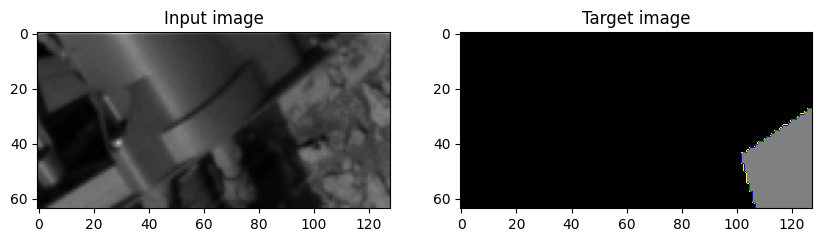

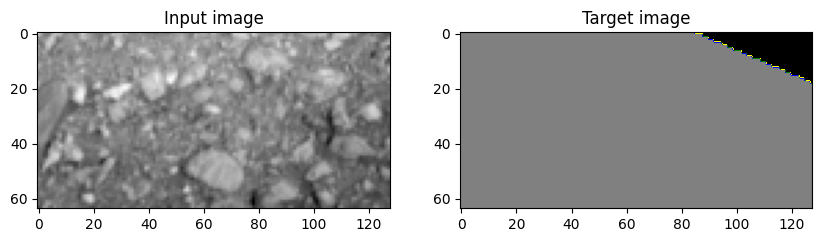

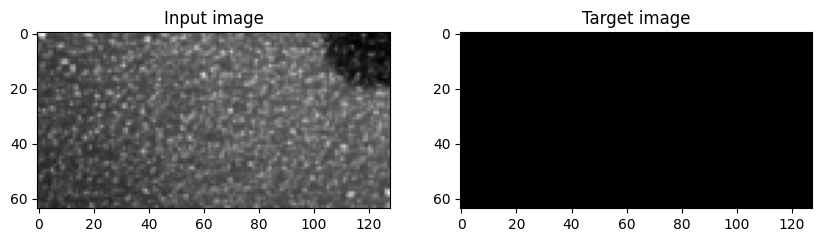

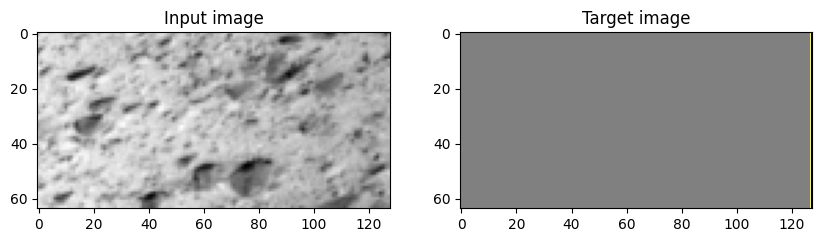

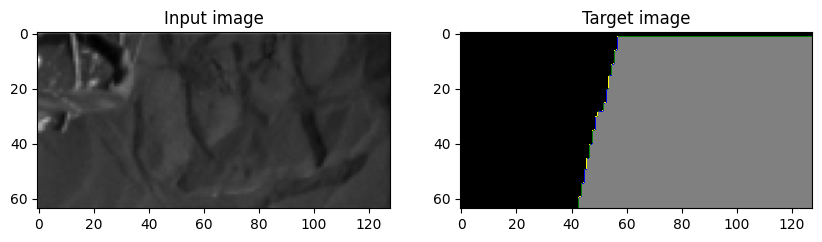

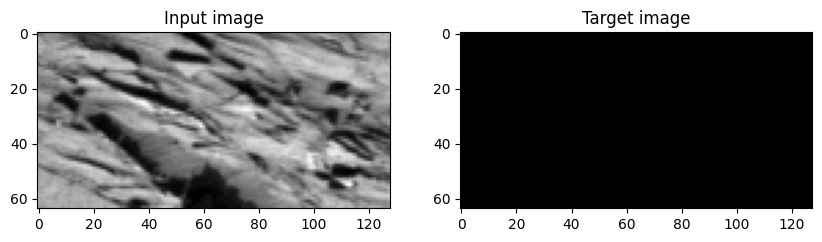

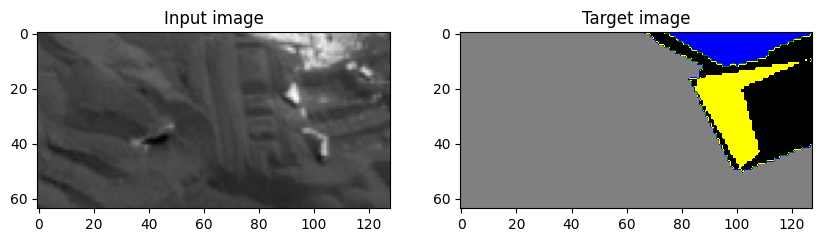

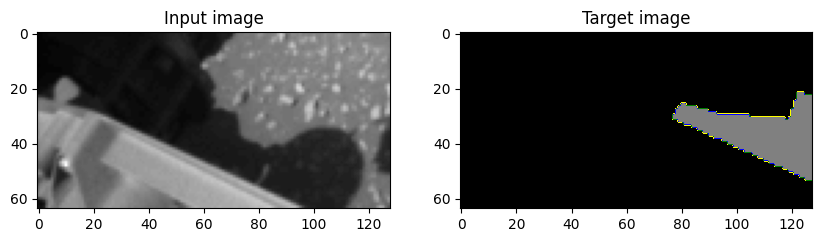

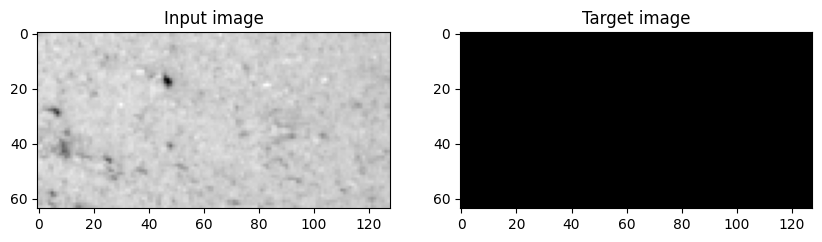

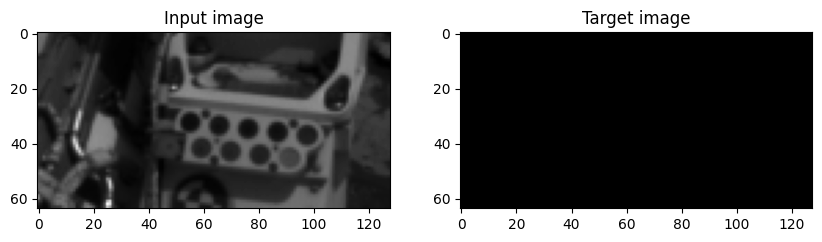

In [13]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=SEED
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = make_dataset(
    test_img, test_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)
print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    display_random_images_and_masks(images, labels, num_images=10)
    break

## 🛠️ Train and Save the Model

In [14]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):

    conv = tfkl.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = tfkl.BatchNormalization(axis=3)(conv)
    conv = tfkl.Activation("relu")(conv)

    conv = tfkl.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = tfkl.BatchNormalization(axis=3)(conv)
    conv = tfkl.Activation("relu")(conv)

    if dropout > 0:
        conv = tfkl.Dropout(dropout)(conv)

    return conv


def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return tfkl.Lambda(lambda x, repnum: tfk.backend.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).

    1. conv - BN - Activation - conv - BN - Activation
                                          - shortcut  - BN - shortcut+BN

    2. conv - BN - Activation - conv - BN
                                     - shortcut  - BN - shortcut+BN - Activation

    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = tfkl.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = tfkl.BatchNormalization(axis=3)(conv)
    conv = tfkl.Activation('relu')(conv)

    conv = tfkl.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = tfkl.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = tfkl.Dropout(dropout)(conv)

    shortcut = tfkl.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = tfkl.BatchNormalization(axis=3)(shortcut)

    res_path = tfkl.add([shortcut, conv])
    res_path = tfkl.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = tfkl.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = tfk.backend.int_shape(x)
    shape_g = tfk.backend.int_shape(gating)

    # Getting the x signal to the same shape as the gating signal
    theta_x = tfkl.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = tfk.backend.int_shape(theta_x)

    # Getting the gating signal to the same number of filters as the inter_shape
    phi_g = tfkl.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = tfkl.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = tfkl.add([upsample_g, theta_x])
    act_xg = tfkl.Activation('relu')(concat_xg)
    psi = tfkl.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = tfkl.Activation('sigmoid')(psi)
    shape_sigmoid = tfk.backend.int_shape(sigmoid_xg)
    upsample_psi = tfkl.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = tfkl.multiply([upsample_psi, x])

    result = tfkl.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = tfkl.BatchNormalization()(result)
    return result_bn


In [15]:
def Attention_ResUNet(input_shape=(64, 128, 1), NUM_CLASSES=NUM_CLASSES, dropout_rate=0.0, batch_norm=True):
    '''
    Rsidual UNet, with attention

    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = tfkl.Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = tfkl.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = tfkl.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = tfkl.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = tfkl.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = tfkl.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = tfkl.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers

    conv_final = tfkl.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = tfkl.BatchNormalization(axis=axis)(conv_final)
    conv_final = tfkl.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = tfk.models.Model(inputs, conv_final, name="AttentionResUNet")
    return model


Model: "AttentionResUNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d (Conv2D)        │ (None, 64, 128, 64)  │          640 │ input_layer[0][0]   │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization    │ (None, 64, 128, 64)  │          256 │ conv2d[0][0]        │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation             │ (None, 64, 128, 64)  │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_2 (Conv2D)      │ (None, 64, 128, 64)  │          128 │ input_layer[0][0]   │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_1 (Conv2D)      │ (None, 64, 128, 64)  │       36,928 │ activation[0][0]    │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_2  │ (None, 64, 128, 64)  │          256 │ conv2d_2[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_1  │ (None, 64, 128, 64)  │          256 │ conv2d_1[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ add (Add)              │ (None, 64, 128, 64)  │            0 │ batch_normalizatio… │    -    │
│                        │                      │              │ batch_normalizatio… │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation_1           │ (None, 64, 128, 64)  │            0 │ add[0][0]           │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d          │ (None, 32, 64, 64)   │            0 │ activation_1[0][0]  │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_3 (Conv2D)      │ (None, 32, 64, 128)  │       73,856 │ max_pooling2d[0][0] │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_3  │ (None, 32, 64, 128)  │          512 │ conv2d_3[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation_2           │ (None, 32, 64, 128)  │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_5 (Conv2D)    

 Total params: 39,089,373 (149.11 MB)

 Trainable params: 39,067,859 (149.03 MB)

 Non-trainable params: 21,514 (84.04 KB)

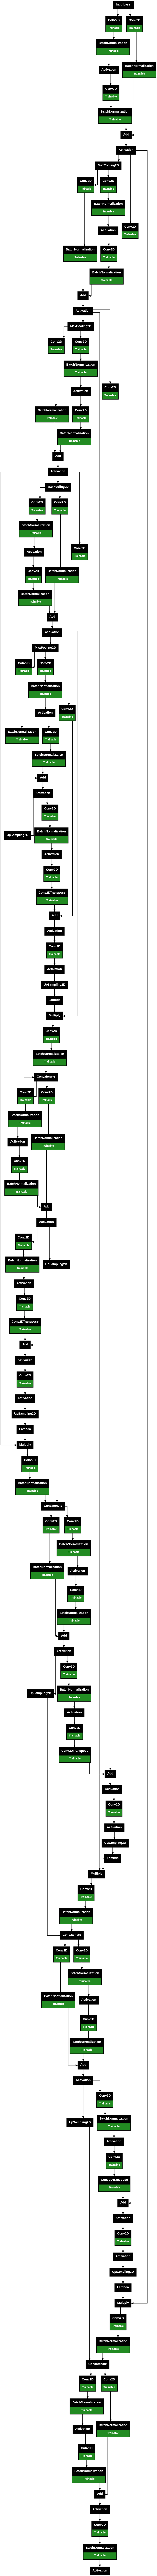

In [16]:
model = Attention_ResUNet()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)


In [17]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def load_single_image(image_ind, label, input_size=( 64, 128)):

    image = X_train[image_ind]
    label = y_train[image_ind]

    return image, label


In [18]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, frequency=5):
        super().__init__()
        self.image_path = image
        self.label_path = label
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = load_single_image(self.image_path, self.label_path)
            label = label #apply_category_mapping(label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap="gray")
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [19]:
# Compile the model
occ = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
class_labels = {
	0: "Background",
	1: "Soil",
	2: "Bedrock",
	3: "Sand",
	4: "Big Rock"
}

for image in y_train:
    # detect if the image countains at least one pixel of a class
    for i in range(5):
        if i in image:
            occ[i] +=1

total_images = len(y_train)

# Calculate inverse frequency: 1 / (class frequency)
inverse_frequency = {class_id: total_images / occ[class_id] if occ[class_id] > 0 else 0 for class_id in occ}

ALPHA = 0.5
BETA = 0.5
GAMMA = 1

import tensorflow.keras.backend as K

def FocalTverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, gamma=GAMMA, smooth=1e-6):

        #flatten label and prediction tensors
        inputs = K.batch_flatten(inputs)
        targets = K.batch_flatten(targets)

        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))

        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)
        FocalTversky = K.pow((1 - Tversky), gamma)

        return FocalTversky

import tensorflow as tf

# Focal Loss function
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    # Clip predictions to prevent log(0) error
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)

    # Cross entropy loss
    cross_entropy_loss = -y_true * tf.math.log(y_pred)

    # Focal loss component
    focal_loss = alpha * tf.math.pow(1 - y_pred, gamma) * cross_entropy_loss
    return tf.reduce_sum(focal_loss, axis=-1)

# Dice Loss function
def dice_loss(y_true, y_pred, epsilon=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred, axis=-1)
    union = tf.reduce_sum(y_true + y_pred, axis=-1)
    dice = 1 - (2.0 * intersection + epsilon) / (union + epsilon)
    return tf.reduce_mean(dice)

# Combined Loss function
def combined_loss(y_true, y_pred, alpha=0.25, gamma=2.0, epsilon=1e-6):
    focal = focal_loss(y_true, y_pred, alpha, gamma)
    dice = dice_loss(y_true, y_pred, epsilon)
    return tf.reduce_mean(focal + dice)



print("Compiling model...")
model.compile(
    #loss=tf.keras.losses.CategoricalFocalCrossentropy(
    #    alpha=tf.constant(list(inverse_frequency.values()), dtype=tf.float32),
    #    gamma=2.0,
    #    label_smoothing = 0.1,
    #    from_logits=True,
    #    reduction = 'sum_over_batch_size',  # Common reduction method for multi-class classification
    #    axis = -1  # Typically, crossentropy is computed along the last axis
    #),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    #loss=combined_loss,
    #loss=FocalTverskyLoss,
    # loss = tfk.losses.Tversky(
    #   alpha=0.5, beta=0.5, reduction="sum_over_batch_size", name="tversky", dtype=None
    # ),
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)
print("Model compiled!")

Compiling model...
Model compiled!


In [20]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback = VizCallback(0, 0)

reduceOnPlateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.1,
    patience=50
)

Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3215 - loss: 1.5924 - mean_iou: 0.1442   

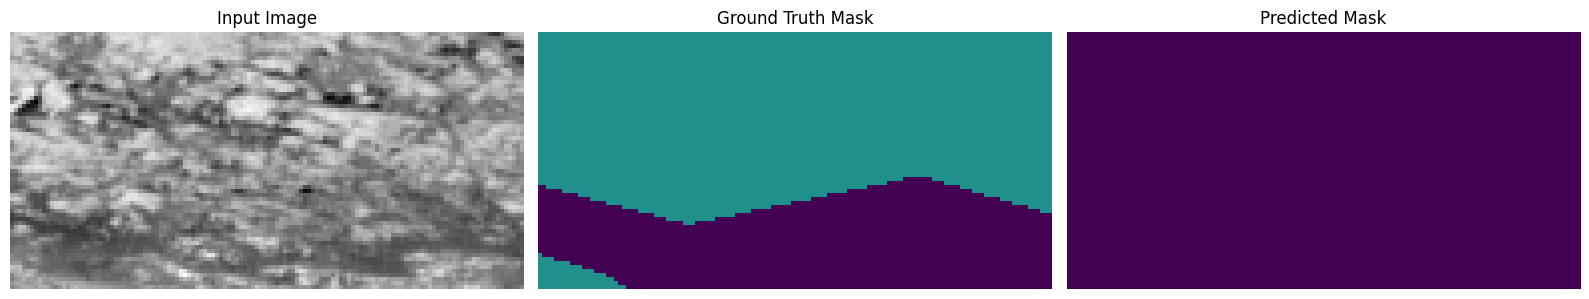

30/30 ━━━━━━━━━━━━━━━━━━━━ 257s 5s/step - accuracy: 0.3237 - loss: 1.5884 - mean_iou: 0.1453 - val_accuracy: 0.2445 - val_loss: 524451.6875 - val_mean_iou: 0.0000e+00 - learning_rate: 0.0100
Epoch 2/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 707ms/step - accuracy: 0.4835 - loss: 1.2786 - mean_iou: 0.2190 - val_accuracy: 0.2445 - val_loss: 3147.1147 - val_mean_iou: 0.0000e+00 - learning_rate: 0.0100
Epoch 3/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 700ms/step - accuracy: 0.5167 - loss: 1.1771 - mean_iou: 0.2443 - val_accuracy: 0.2370 - val_loss: 23.0560 - val_mean_iou: 0.0030 - learning_rate: 0.0100
Epoch 4/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 692ms/step - accuracy: 0.5843 - loss: 1.0619 - mean_iou: 0.2975 - val_accuracy: 0.2672 - val_loss: 3.7848 - val_mean_iou: 0.0516 - learning_rate: 0.0100
Epoch 5/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 688ms/step - accuracy: 0.6023 - loss: 1.0142 - mean_iou: 0.3183 - val_accuracy: 0.3333 - val_loss: 5.0889 - val_mean_iou: 0.1131 - learning_rate: 0.0100
Epoch 6/500
30/30

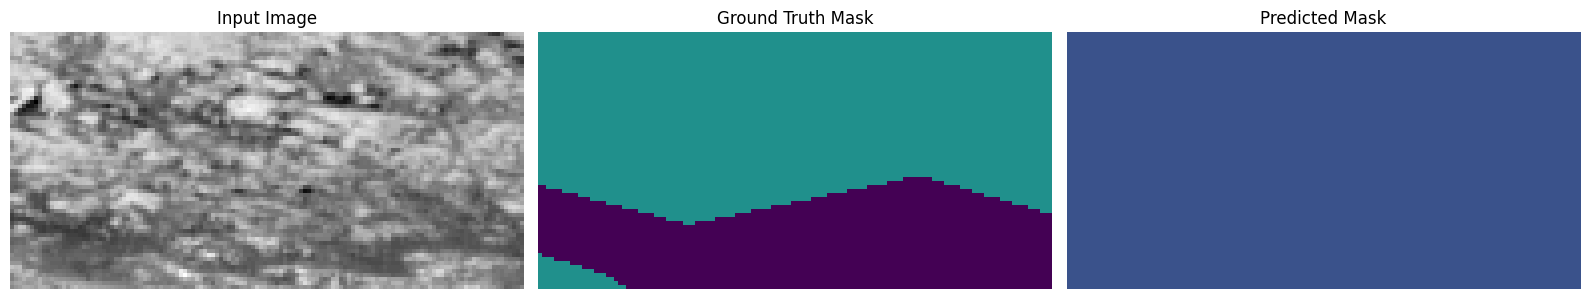

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 705ms/step - accuracy: 0.6059 - loss: 0.9908 - mean_iou: 0.3245 - val_accuracy: 0.3310 - val_loss: 5.4479 - val_mean_iou: 0.1095 - learning_rate: 0.0100
Epoch 7/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 698ms/step - accuracy: 0.6463 - loss: 0.9115 - mean_iou: 0.3567 - val_accuracy: 0.3310 - val_loss: 5.5857 - val_mean_iou: 0.1095 - learning_rate: 0.0100
Epoch 8/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 697ms/step - accuracy: 0.6463 - loss: 0.9010 - mean_iou: 0.3537 - val_accuracy: 0.3865 - val_loss: 3.4118 - val_mean_iou: 0.1764 - learning_rate: 0.0100
Epoch 9/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 695ms/step - accuracy: 0.6586 - loss: 0.8756 - mean_iou: 0.3646 - val_accuracy: 0.4065 - val_loss: 3.7533 - val_mean_iou: 0.2422 - learning_rate: 0.0100
Epoch 10/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 693ms/step - accuracy: 0.6818 - loss: 0.8259 - mean_iou: 0.3960 - val_accuracy: 0.3684 - val_loss: 3.7551 - val_mean_iou: 0.1692 - learning_rate: 0.0100
Epoch 11/500
30/30 ━━━━━━━━━━━━

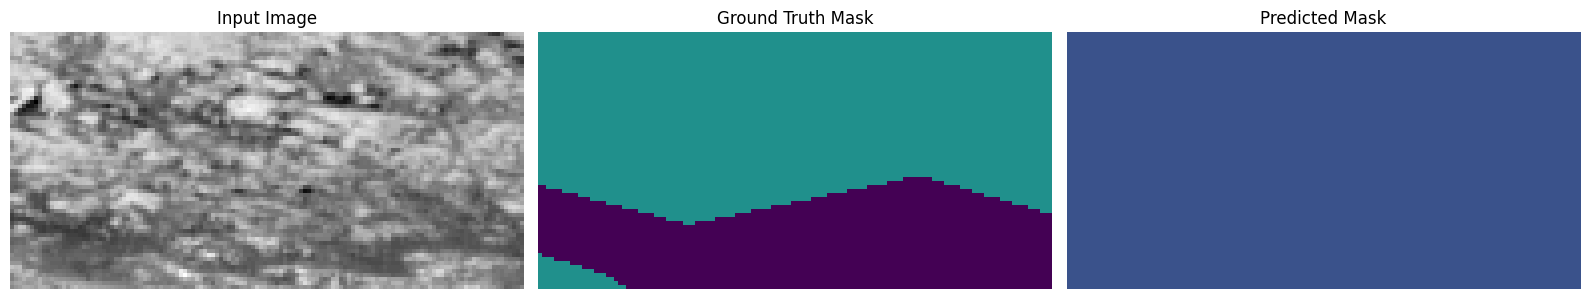

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 710ms/step - accuracy: 0.6682 - loss: 0.8488 - mean_iou: 0.3749 - val_accuracy: 0.4692 - val_loss: 2.0731 - val_mean_iou: 0.2392 - learning_rate: 0.0100
Epoch 12/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 690ms/step - accuracy: 0.6937 - loss: 0.7836 - mean_iou: 0.4020 - val_accuracy: 0.3657 - val_loss: 3.0130 - val_mean_iou: 0.1194 - learning_rate: 0.0100
Epoch 13/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 689ms/step - accuracy: 0.6950 - loss: 0.7788 - mean_iou: 0.4046 - val_accuracy: 0.4117 - val_loss: 2.8692 - val_mean_iou: 0.1979 - learning_rate: 0.0100
Epoch 14/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 695ms/step - accuracy: 0.7090 - loss: 0.7576 - mean_iou: 0.4148 - val_accuracy: 0.4310 - val_loss: 2.2110 - val_mean_iou: 0.2095 - learning_rate: 0.0100
Epoch 15/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 694ms/step - accuracy: 0.7035 - loss: 0.7632 - mean_iou: 0.4093 - val_accuracy: 0.4016 - val_loss: 2.1863 - val_mean_iou: 0.2081 - learning_rate: 0.0100
Epoch 16/500
30/30 ━━━━━━━━━

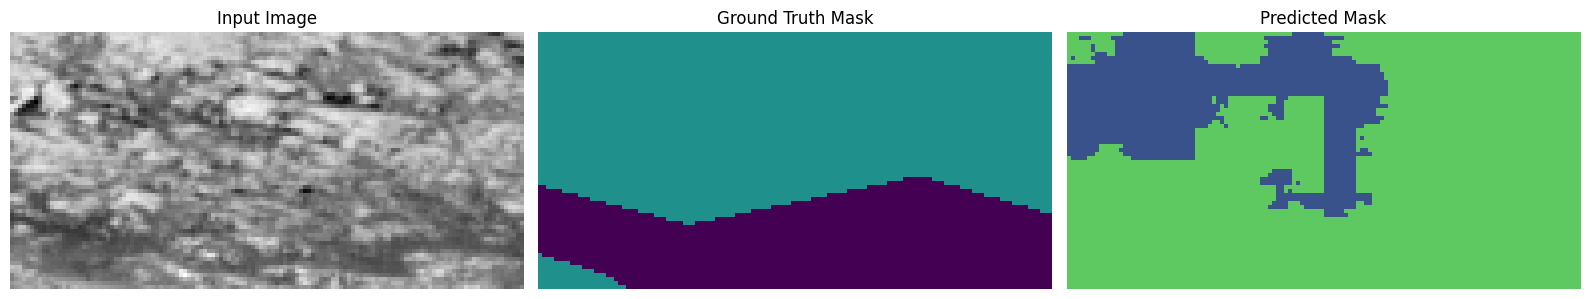

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 704ms/step - accuracy: 0.7163 - loss: 0.7368 - mean_iou: 0.4230 - val_accuracy: 0.4410 - val_loss: 2.6453 - val_mean_iou: 0.2335 - learning_rate: 0.0100
Epoch 17/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 697ms/step - accuracy: 0.7162 - loss: 0.7331 - mean_iou: 0.4227 - val_accuracy: 0.5201 - val_loss: 1.4871 - val_mean_iou: 0.2972 - learning_rate: 0.0100
Epoch 18/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 696ms/step - accuracy: 0.7248 - loss: 0.7091 - mean_iou: 0.4260 - val_accuracy: 0.5289 - val_loss: 1.4330 - val_mean_iou: 0.3034 - learning_rate: 0.0100
Epoch 19/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 697ms/step - accuracy: 0.7163 - loss: 0.7330 - mean_iou: 0.4161 - val_accuracy: 0.5686 - val_loss: 1.2835 - val_mean_iou: 0.3077 - learning_rate: 0.0100
Epoch 20/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 701ms/step - accuracy: 0.7332 - loss: 0.7087 - mean_iou: 0.4345 - val_accuracy: 0.6663 - val_loss: 0.8938 - val_mean_iou: 0.4083 - learning_rate: 0.0100
Epoch 21/500
30/30 ━━━━━━━━━

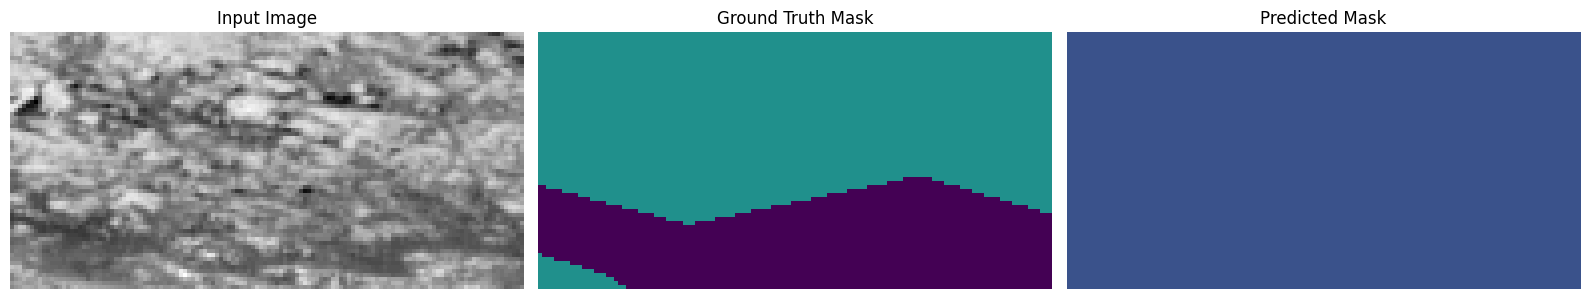

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 705ms/step - accuracy: 0.7345 - loss: 0.6961 - mean_iou: 0.4393 - val_accuracy: 0.5755 - val_loss: 1.4610 - val_mean_iou: 0.3021 - learning_rate: 0.0100
Epoch 22/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 689ms/step - accuracy: 0.7424 - loss: 0.6650 - mean_iou: 0.4444 - val_accuracy: 0.6051 - val_loss: 1.0450 - val_mean_iou: 0.3566 - learning_rate: 0.0100
Epoch 23/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 692ms/step - accuracy: 0.7396 - loss: 0.6656 - mean_iou: 0.4439 - val_accuracy: 0.6082 - val_loss: 1.3254 - val_mean_iou: 0.3548 - learning_rate: 0.0100
Epoch 24/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 699ms/step - accuracy: 0.7468 - loss: 0.6672 - mean_iou: 0.4470 - val_accuracy: 0.7020 - val_loss: 0.8275 - val_mean_iou: 0.4448 - learning_rate: 0.0100
Epoch 25/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 697ms/step - accuracy: 0.7508 - loss: 0.6490 - mean_iou: 0.4545 - val_accuracy: 0.5608 - val_loss: 1.4743 - val_mean_iou: 0.2697 - learning_rate: 0.0100
Epoch 26/500
30/30 ━━━━━━━━━

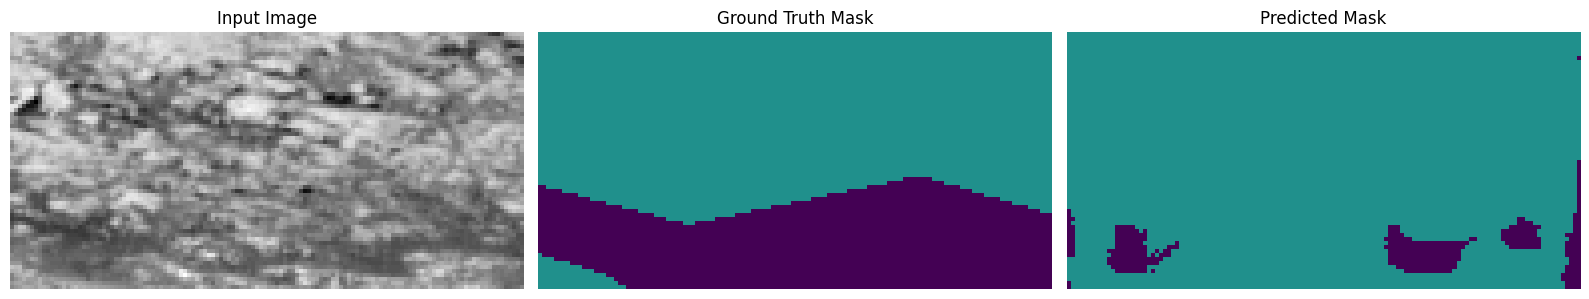

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 701ms/step - accuracy: 0.7460 - loss: 0.6551 - mean_iou: 0.4458 - val_accuracy: 0.6688 - val_loss: 0.9628 - val_mean_iou: 0.3660 - learning_rate: 0.0100
Epoch 27/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 689ms/step - accuracy: 0.7391 - loss: 0.6658 - mean_iou: 0.4387 - val_accuracy: 0.6035 - val_loss: 1.5392 - val_mean_iou: 0.3144 - learning_rate: 0.0100
Epoch 28/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 692ms/step - accuracy: 0.7439 - loss: 0.6550 - mean_iou: 0.4526 - val_accuracy: 0.4622 - val_loss: 2.4311 - val_mean_iou: 0.1780 - learning_rate: 0.0100
Epoch 29/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 694ms/step - accuracy: 0.7576 - loss: 0.6335 - mean_iou: 0.4609 - val_accuracy: 0.5690 - val_loss: 1.3282 - val_mean_iou: 0.2736 - learning_rate: 0.0100
Epoch 30/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 697ms/step - accuracy: 0.7511 - loss: 0.6311 - mean_iou: 0.4487 - val_accuracy: 0.3474 - val_loss: 2.0805 - val_mean_iou: 0.1006 - learning_rate: 0.0100
Epoch 31/500
30/30 ━━━━━━━━━

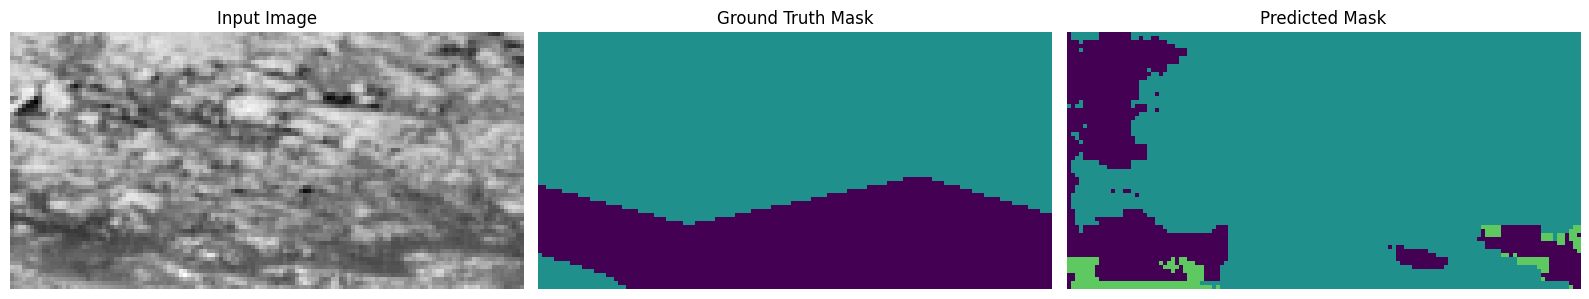

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 702ms/step - accuracy: 0.7633 - loss: 0.6190 - mean_iou: 0.4615 - val_accuracy: 0.5242 - val_loss: 1.4336 - val_mean_iou: 0.2337 - learning_rate: 0.0100
Epoch 32/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 688ms/step - accuracy: 0.7637 - loss: 0.5993 - mean_iou: 0.4627 - val_accuracy: 0.6801 - val_loss: 0.9324 - val_mean_iou: 0.3754 - learning_rate: 0.0100
Epoch 33/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 693ms/step - accuracy: 0.7644 - loss: 0.6077 - mean_iou: 0.4617 - val_accuracy: 0.5935 - val_loss: 1.3000 - val_mean_iou: 0.3010 - learning_rate: 0.0100
Epoch 34/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 694ms/step - accuracy: 0.7687 - loss: 0.5949 - mean_iou: 0.4670 - val_accuracy: 0.5851 - val_loss: 1.1968 - val_mean_iou: 0.2936 - learning_rate: 0.0100
Epoch 35/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 699ms/step - accuracy: 0.7659 - loss: 0.5971 - mean_iou: 0.4650 - val_accuracy: 0.7147 - val_loss: 0.8379 - val_mean_iou: 0.4091 - learning_rate: 0.0100
Epoch 36/500
30/30 ━━━━━━━━━

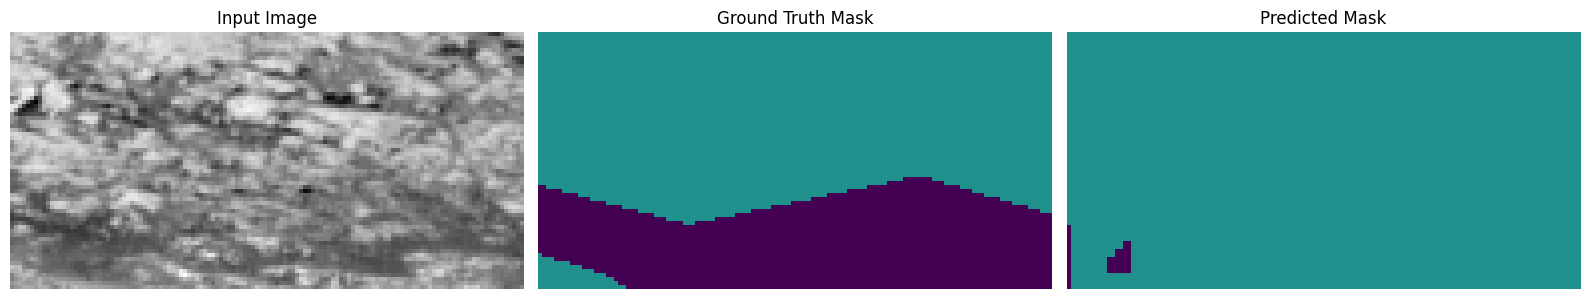

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 701ms/step - accuracy: 0.7609 - loss: 0.6030 - mean_iou: 0.4542 - val_accuracy: 0.5239 - val_loss: 1.5760 - val_mean_iou: 0.2327 - learning_rate: 0.0100
Epoch 37/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 693ms/step - accuracy: 0.7704 - loss: 0.5892 - mean_iou: 0.4684 - val_accuracy: 0.5315 - val_loss: 1.3404 - val_mean_iou: 0.2270 - learning_rate: 0.0100
Epoch 38/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 695ms/step - accuracy: 0.7788 - loss: 0.5677 - mean_iou: 0.4762 - val_accuracy: 0.6995 - val_loss: 0.8539 - val_mean_iou: 0.4142 - learning_rate: 0.0100
Epoch 39/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 693ms/step - accuracy: 0.7817 - loss: 0.5702 - mean_iou: 0.4776 - val_accuracy: 0.7082 - val_loss: 0.8293 - val_mean_iou: 0.3913 - learning_rate: 0.0100
Epoch 40/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 692ms/step - accuracy: 0.7841 - loss: 0.5590 - mean_iou: 0.4818 - val_accuracy: 0.6802 - val_loss: 0.8910 - val_mean_iou: 0.3559 - learning_rate: 0.0100
Epoch 41/500
30/30 ━━━━━━━━━

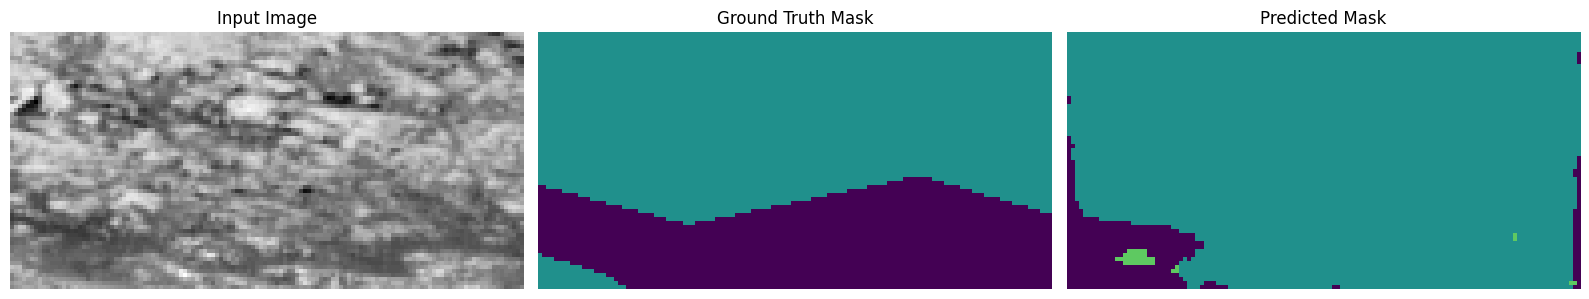

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 698ms/step - accuracy: 0.7832 - loss: 0.5579 - mean_iou: 0.4823 - val_accuracy: 0.6643 - val_loss: 0.9771 - val_mean_iou: 0.3453 - learning_rate: 0.0100
Epoch 42/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 691ms/step - accuracy: 0.7859 - loss: 0.5636 - mean_iou: 0.4830 - val_accuracy: 0.7128 - val_loss: 0.8700 - val_mean_iou: 0.4034 - learning_rate: 0.0100
Epoch 43/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 697ms/step - accuracy: 0.7849 - loss: 0.5529 - mean_iou: 0.4786 - val_accuracy: 0.7176 - val_loss: 0.7403 - val_mean_iou: 0.4191 - learning_rate: 0.0100
Epoch 44/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 695ms/step - accuracy: 0.8028 - loss: 0.5123 - mean_iou: 0.4957 - val_accuracy: 0.5769 - val_loss: 1.5382 - val_mean_iou: 0.2449 - learning_rate: 0.0100
Epoch 45/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 693ms/step - accuracy: 0.8033 - loss: 0.5107 - mean_iou: 0.4981 - val_accuracy: 0.5855 - val_loss: 1.7921 - val_mean_iou: 0.2761 - learning_rate: 0.0100
Epoch 46/500
30/30 ━━━━━━━━━

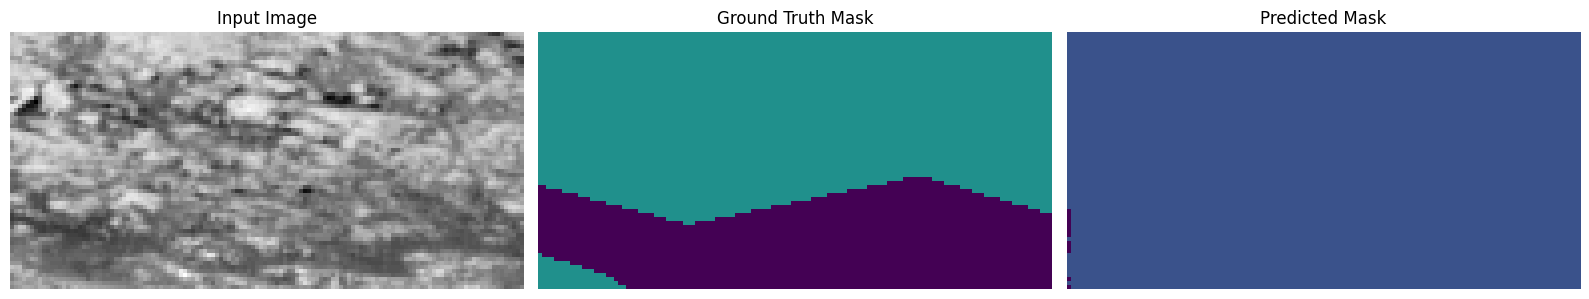

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 699ms/step - accuracy: 0.7913 - loss: 0.5462 - mean_iou: 0.4855 - val_accuracy: 0.4387 - val_loss: 2.4615 - val_mean_iou: 0.1461 - learning_rate: 0.0100
Epoch 47/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 693ms/step - accuracy: 0.8041 - loss: 0.4959 - mean_iou: 0.5004 - val_accuracy: 0.5933 - val_loss: 1.5214 - val_mean_iou: 0.2973 - learning_rate: 0.0100
Epoch 48/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 694ms/step - accuracy: 0.7934 - loss: 0.5370 - mean_iou: 0.4846 - val_accuracy: 0.5406 - val_loss: 1.9620 - val_mean_iou: 0.2042 - learning_rate: 0.0100
Epoch 49/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 696ms/step - accuracy: 0.8079 - loss: 0.5008 - mean_iou: 0.5010 - val_accuracy: 0.6650 - val_loss: 1.0376 - val_mean_iou: 0.3492 - learning_rate: 0.0100
Epoch 50/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 689ms/step - accuracy: 0.8149 - loss: 0.4793 - mean_iou: 0.5084 - val_accuracy: 0.7093 - val_loss: 0.8606 - val_mean_iou: 0.3976 - learning_rate: 0.0100
Epoch 51/500
30/30 ━━━━━━━━━

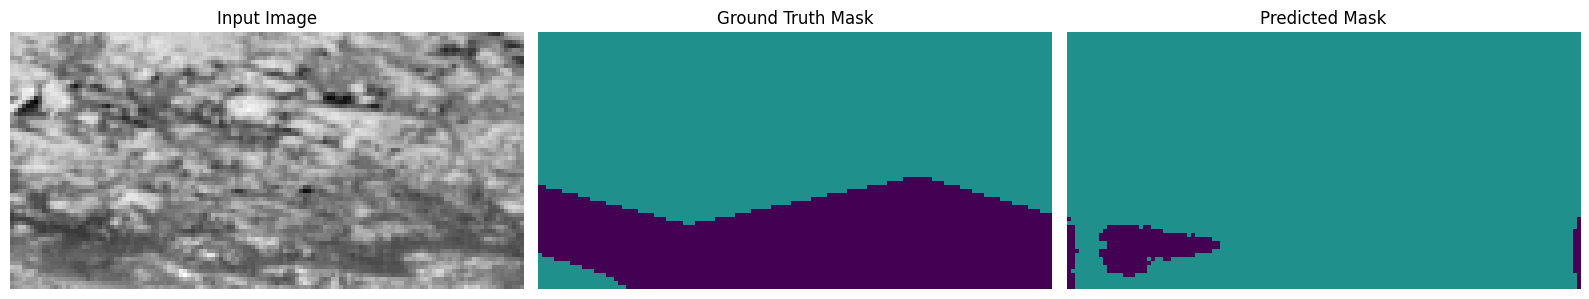

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 701ms/step - accuracy: 0.8165 - loss: 0.4799 - mean_iou: 0.5073 - val_accuracy: 0.6983 - val_loss: 0.9053 - val_mean_iou: 0.3988 - learning_rate: 0.0100
Epoch 52/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 696ms/step - accuracy: 0.8202 - loss: 0.4680 - mean_iou: 0.5066 - val_accuracy: 0.7325 - val_loss: 0.7809 - val_mean_iou: 0.4147 - learning_rate: 0.0100
Epoch 53/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 695ms/step - accuracy: 0.8216 - loss: 0.4654 - mean_iou: 0.5135 - val_accuracy: 0.6992 - val_loss: 0.9201 - val_mean_iou: 0.3960 - learning_rate: 0.0100
Epoch 54/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 694ms/step - accuracy: 0.8267 - loss: 0.4513 - mean_iou: 0.5153 - val_accuracy: 0.7188 - val_loss: 0.9728 - val_mean_iou: 0.4127 - learning_rate: 0.0100
Epoch 55/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 692ms/step - accuracy: 0.8325 - loss: 0.4390 - mean_iou: 0.5166 - val_accuracy: 0.6458 - val_loss: 1.2324 - val_mean_iou: 0.3162 - learning_rate: 0.0100
Epoch 56/500
30/30 ━━━━━━━━━

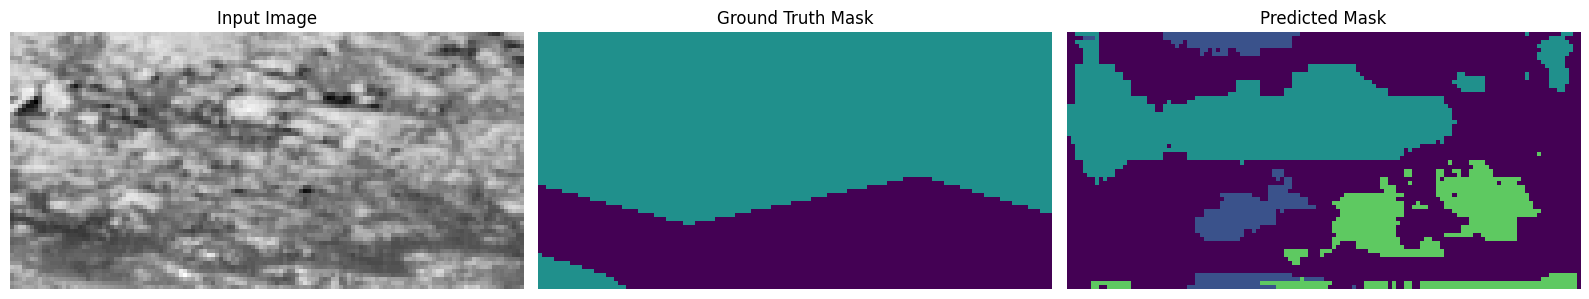

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 699ms/step - accuracy: 0.8343 - loss: 0.4394 - mean_iou: 0.5205 - val_accuracy: 0.6860 - val_loss: 0.9068 - val_mean_iou: 0.3556 - learning_rate: 0.0100
Epoch 57/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 692ms/step - accuracy: 0.8336 - loss: 0.4379 - mean_iou: 0.5165 - val_accuracy: 0.5304 - val_loss: 1.7833 - val_mean_iou: 0.2148 - learning_rate: 0.0100
Epoch 58/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 716ms/step - accuracy: 0.8381 - loss: 0.4188 - mean_iou: 0.5185 - val_accuracy: 0.7412 - val_loss: 0.8185 - val_mean_iou: 0.4158 - learning_rate: 0.0100
Epoch 59/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 693ms/step - accuracy: 0.8475 - loss: 0.3960 - mean_iou: 0.5363 - val_accuracy: 0.6423 - val_loss: 1.1943 - val_mean_iou: 0.3086 - learning_rate: 0.0100
Epoch 60/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 689ms/step - accuracy: 0.8445 - loss: 0.4023 - mean_iou: 0.5275 - val_accuracy: 0.4725 - val_loss: 2.5086 - val_mean_iou: 0.1712 - learning_rate: 0.0100
Epoch 61/500
30/30 ━━━━━━━━━

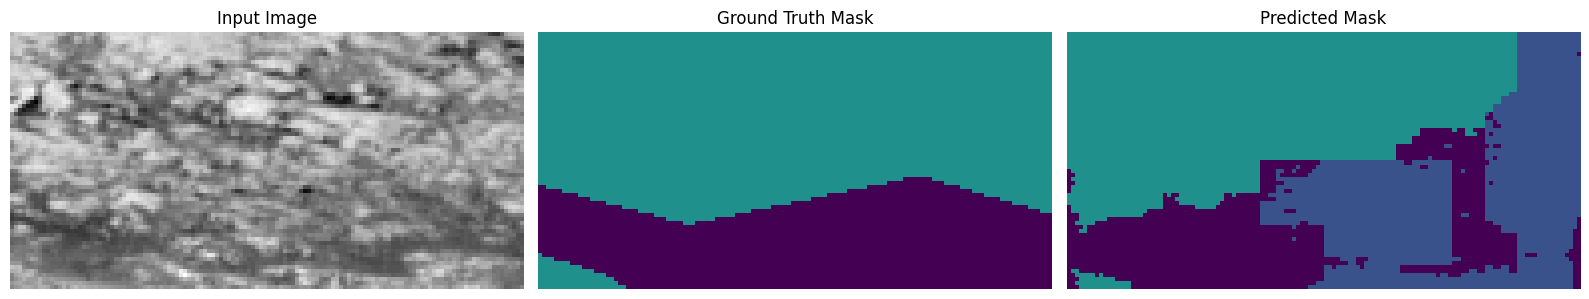

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 700ms/step - accuracy: 0.8561 - loss: 0.3747 - mean_iou: 0.5318 - val_accuracy: 0.6338 - val_loss: 1.3415 - val_mean_iou: 0.3021 - learning_rate: 0.0100
Epoch 62/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 692ms/step - accuracy: 0.8519 - loss: 0.3944 - mean_iou: 0.5321 - val_accuracy: 0.6710 - val_loss: 1.2589 - val_mean_iou: 0.3363 - learning_rate: 0.0100
Epoch 63/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 695ms/step - accuracy: 0.8490 - loss: 0.3885 - mean_iou: 0.5250 - val_accuracy: 0.7352 - val_loss: 0.7961 - val_mean_iou: 0.4138 - learning_rate: 0.0100
Epoch 64/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 683ms/step - accuracy: 0.8565 - loss: 0.3725 - mean_iou: 0.5247 - val_accuracy: 0.6949 - val_loss: 0.9488 - val_mean_iou: 0.3685 - learning_rate: 0.0100
Epoch 65/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 714ms/step - accuracy: 0.8670 - loss: 0.3487 - mean_iou: 0.5344 - val_accuracy: 0.6805 - val_loss: 1.0650 - val_mean_iou: 0.3522 - learning_rate: 0.0100
Epoch 66/500
30/30 ━━━━━━━━━

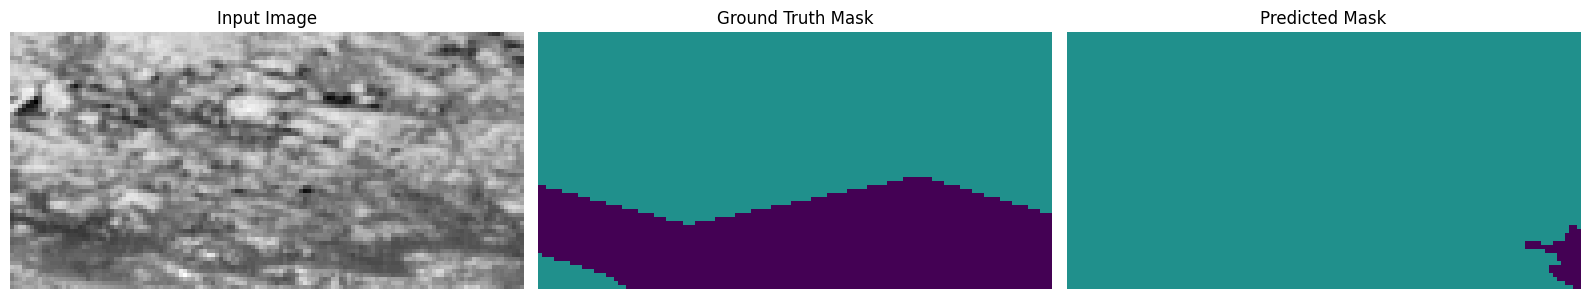

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 708ms/step - accuracy: 0.8736 - loss: 0.3342 - mean_iou: 0.5412 - val_accuracy: 0.7082 - val_loss: 1.0069 - val_mean_iou: 0.3934 - learning_rate: 0.0100
Epoch 67/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 685ms/step - accuracy: 0.8753 - loss: 0.3402 - mean_iou: 0.5438 - val_accuracy: 0.7380 - val_loss: 0.8530 - val_mean_iou: 0.4473 - learning_rate: 0.0100
Epoch 68/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 686ms/step - accuracy: 0.8671 - loss: 0.3495 - mean_iou: 0.5362 - val_accuracy: 0.6943 - val_loss: 1.0454 - val_mean_iou: 0.3882 - learning_rate: 0.0100
Epoch 69/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 695ms/step - accuracy: 0.8844 - loss: 0.3131 - mean_iou: 0.5483 - val_accuracy: 0.6030 - val_loss: 1.6240 - val_mean_iou: 0.2731 - learning_rate: 0.0100
Epoch 70/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 694ms/step - accuracy: 0.8809 - loss: 0.3178 - mean_iou: 0.5408 - val_accuracy: 0.6449 - val_loss: 1.0076 - val_mean_iou: 0.3376 - learning_rate: 0.0100
Epoch 71/500
30/30 ━━━━━━━━━

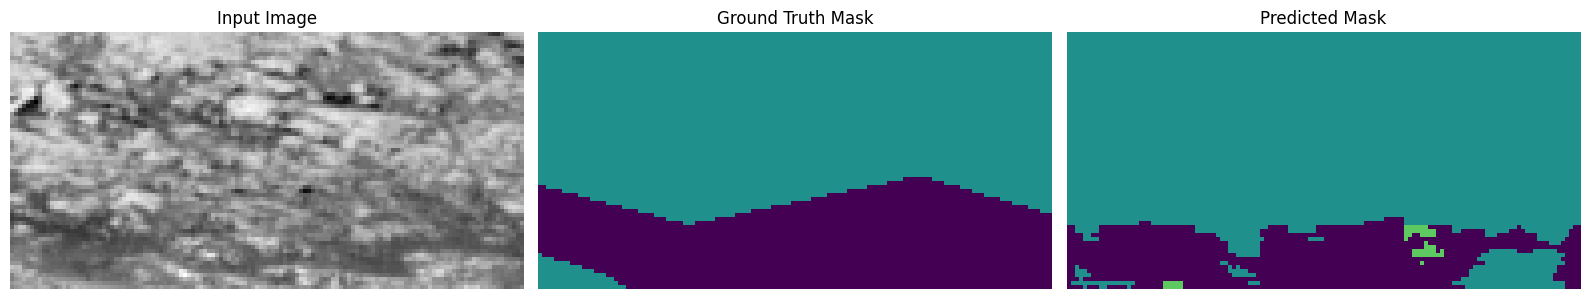

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 706ms/step - accuracy: 0.8761 - loss: 0.3281 - mean_iou: 0.5389 - val_accuracy: 0.7480 - val_loss: 0.7861 - val_mean_iou: 0.4330 - learning_rate: 0.0100
Epoch 72/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 689ms/step - accuracy: 0.8867 - loss: 0.3024 - mean_iou: 0.5510 - val_accuracy: 0.7191 - val_loss: 0.8942 - val_mean_iou: 0.3910 - learning_rate: 0.0100
Epoch 73/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 689ms/step - accuracy: 0.8951 - loss: 0.2787 - mean_iou: 0.5512 - val_accuracy: 0.6592 - val_loss: 1.1844 - val_mean_iou: 0.3344 - learning_rate: 0.0100
Epoch 74/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 697ms/step - accuracy: 0.9060 - loss: 0.2569 - mean_iou: 0.5589 - val_accuracy: 0.7786 - val_loss: 0.6327 - val_mean_iou: 0.4651 - learning_rate: 0.0100
Epoch 75/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 694ms/step - accuracy: 0.9011 - loss: 0.2688 - mean_iou: 0.5546 - val_accuracy: 0.6766 - val_loss: 0.9512 - val_mean_iou: 0.3663 - learning_rate: 0.0100
Epoch 76/500
30/30 ━━━━━━━━━

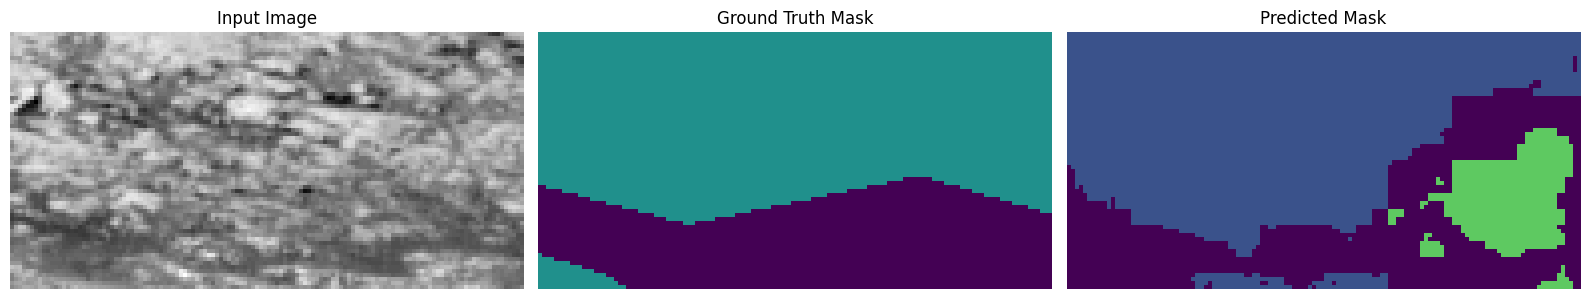

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 701ms/step - accuracy: 0.8923 - loss: 0.2921 - mean_iou: 0.5447 - val_accuracy: 0.6601 - val_loss: 1.0834 - val_mean_iou: 0.3431 - learning_rate: 0.0100
Epoch 77/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 693ms/step - accuracy: 0.9055 - loss: 0.2545 - mean_iou: 0.5575 - val_accuracy: 0.7550 - val_loss: 0.6949 - val_mean_iou: 0.4598 - learning_rate: 0.0100
Epoch 78/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 690ms/step - accuracy: 0.9000 - loss: 0.2698 - mean_iou: 0.5516 - val_accuracy: 0.7108 - val_loss: 0.8533 - val_mean_iou: 0.4040 - learning_rate: 0.0100
Epoch 79/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 690ms/step - accuracy: 0.8967 - loss: 0.2782 - mean_iou: 0.5489 - val_accuracy: 0.6869 - val_loss: 0.9313 - val_mean_iou: 0.3603 - learning_rate: 0.0100
Epoch 80/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 694ms/step - accuracy: 0.8997 - loss: 0.2685 - mean_iou: 0.5529 - val_accuracy: 0.5333 - val_loss: 1.6528 - val_mean_iou: 0.2228 - learning_rate: 0.0100
Epoch 81/500
30/30 ━━━━━━━━━

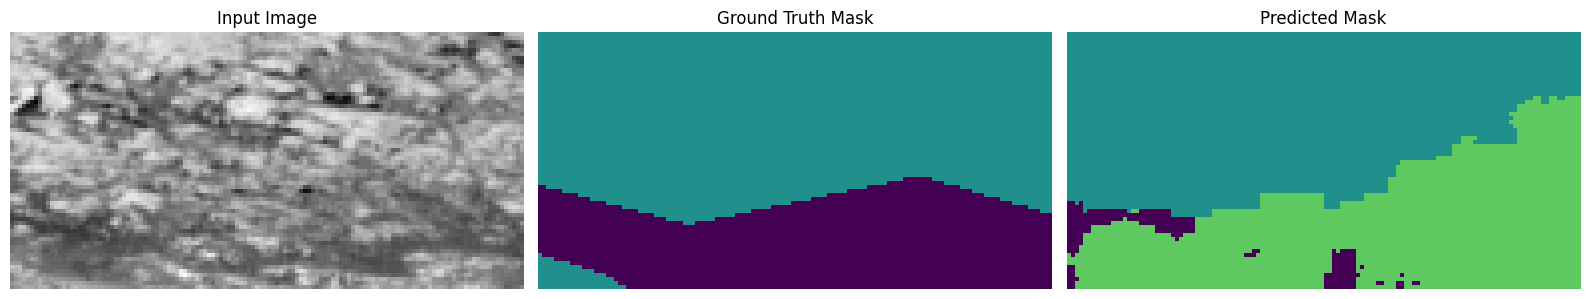

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 703ms/step - accuracy: 0.9112 - loss: 0.2451 - mean_iou: 0.5567 - val_accuracy: 0.7186 - val_loss: 0.8805 - val_mean_iou: 0.4085 - learning_rate: 0.0100
Epoch 82/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 692ms/step - accuracy: 0.9073 - loss: 0.2538 - mean_iou: 0.5568 - val_accuracy: 0.6338 - val_loss: 1.1786 - val_mean_iou: 0.3164 - learning_rate: 0.0100
Epoch 83/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 687ms/step - accuracy: 0.9080 - loss: 0.2520 - mean_iou: 0.5536 - val_accuracy: 0.6248 - val_loss: 1.4038 - val_mean_iou: 0.3009 - learning_rate: 0.0100
Epoch 84/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 690ms/step - accuracy: 0.9176 - loss: 0.2248 - mean_iou: 0.5610 - val_accuracy: 0.7380 - val_loss: 0.7432 - val_mean_iou: 0.4344 - learning_rate: 0.0100
Epoch 85/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 693ms/step - accuracy: 0.9176 - loss: 0.2247 - mean_iou: 0.5620 - val_accuracy: 0.7765 - val_loss: 0.6339 - val_mean_iou: 0.4617 - learning_rate: 0.0100
Epoch 86/500
30/30 ━━━━━━━━━

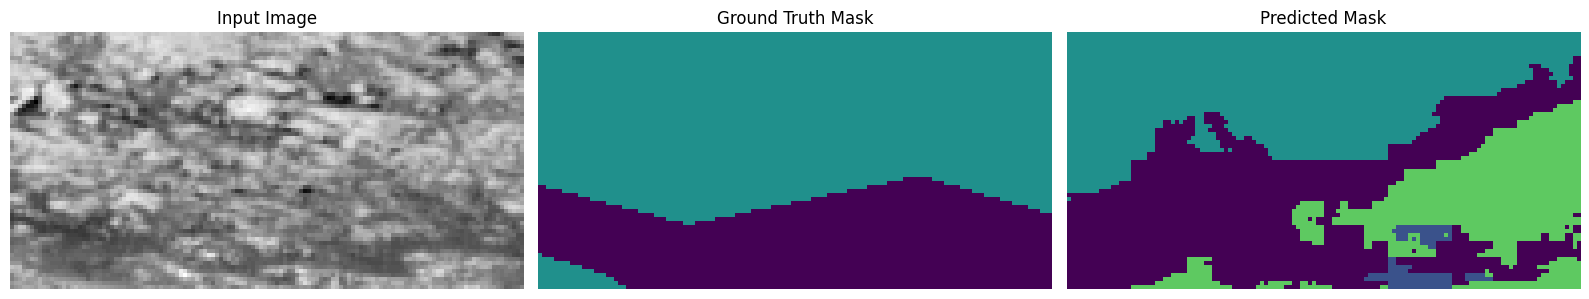

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 697ms/step - accuracy: 0.9200 - loss: 0.2193 - mean_iou: 0.5652 - val_accuracy: 0.6794 - val_loss: 1.0091 - val_mean_iou: 0.3575 - learning_rate: 0.0100
Epoch 87/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 687ms/step - accuracy: 0.9131 - loss: 0.2356 - mean_iou: 0.5599 - val_accuracy: 0.7282 - val_loss: 0.8595 - val_mean_iou: 0.4059 - learning_rate: 0.0100
Epoch 88/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 687ms/step - accuracy: 0.9251 - loss: 0.2055 - mean_iou: 0.5722 - val_accuracy: 0.6906 - val_loss: 1.0299 - val_mean_iou: 0.3807 - learning_rate: 0.0100
Epoch 89/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 689ms/step - accuracy: 0.9288 - loss: 0.1936 - mean_iou: 0.5776 - val_accuracy: 0.7595 - val_loss: 0.7230 - val_mean_iou: 0.4414 - learning_rate: 0.0100
Epoch 90/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 690ms/step - accuracy: 0.9287 - loss: 0.1973 - mean_iou: 0.5680 - val_accuracy: 0.7058 - val_loss: 0.8964 - val_mean_iou: 0.3957 - learning_rate: 0.0100
Epoch 91/500
30/30 ━━━━━━━━━

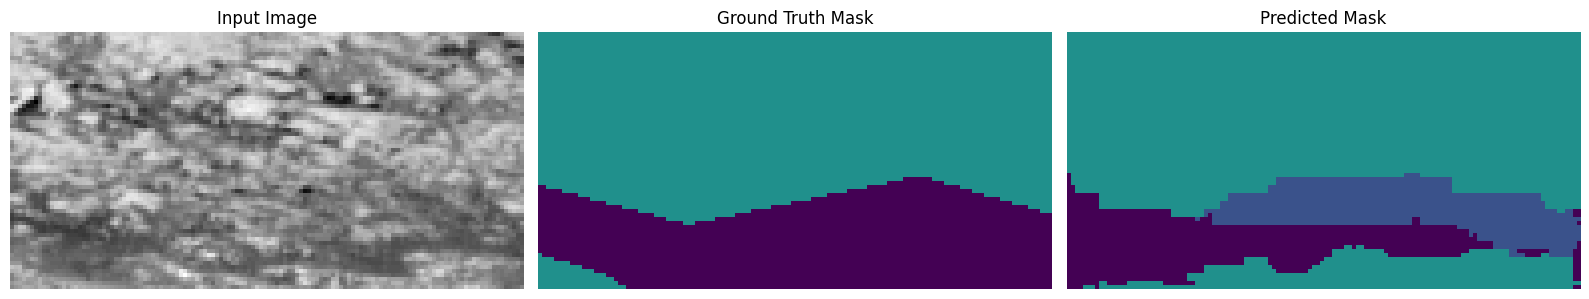

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 699ms/step - accuracy: 0.9236 - loss: 0.2108 - mean_iou: 0.5644 - val_accuracy: 0.7321 - val_loss: 0.8016 - val_mean_iou: 0.4210 - learning_rate: 0.0100
Epoch 92/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 688ms/step - accuracy: 0.9310 - loss: 0.1865 - mean_iou: 0.5698 - val_accuracy: 0.7070 - val_loss: 0.9459 - val_mean_iou: 0.3788 - learning_rate: 0.0100
Epoch 93/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 689ms/step - accuracy: 0.9376 - loss: 0.1691 - mean_iou: 0.5800 - val_accuracy: 0.7395 - val_loss: 0.8547 - val_mean_iou: 0.4283 - learning_rate: 0.0100
Epoch 94/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 688ms/step - accuracy: 0.9370 - loss: 0.1715 - mean_iou: 0.5755 - val_accuracy: 0.7028 - val_loss: 0.9734 - val_mean_iou: 0.3816 - learning_rate: 0.0100
Epoch 95/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 690ms/step - accuracy: 0.9287 - loss: 0.1921 - mean_iou: 0.5790 - val_accuracy: 0.5504 - val_loss: 1.5612 - val_mean_iou: 0.2704 - learning_rate: 0.0100
Epoch 96/500
30/30 ━━━━━━━━━

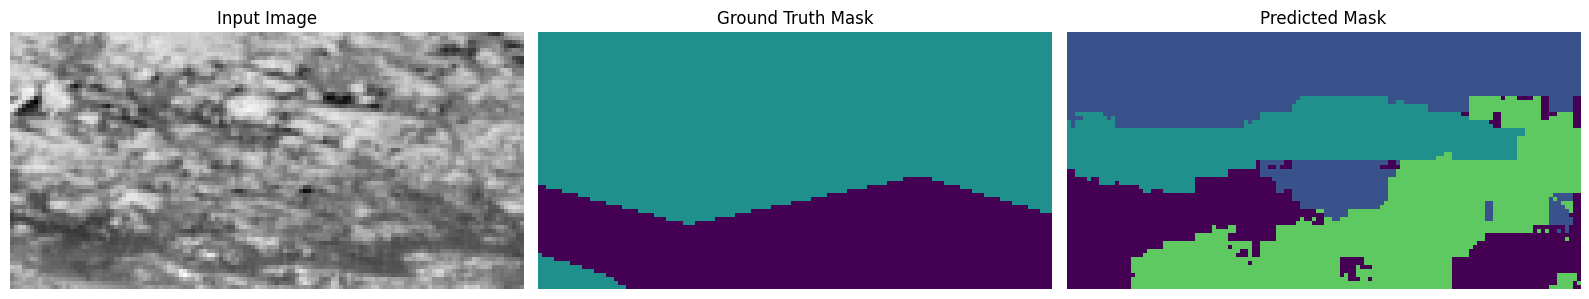

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 699ms/step - accuracy: 0.9227 - loss: 0.2114 - mean_iou: 0.5630 - val_accuracy: 0.7043 - val_loss: 1.0037 - val_mean_iou: 0.4070 - learning_rate: 0.0100
Epoch 97/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 691ms/step - accuracy: 0.9315 - loss: 0.1857 - mean_iou: 0.5873 - val_accuracy: 0.7093 - val_loss: 0.9628 - val_mean_iou: 0.3925 - learning_rate: 0.0100
Epoch 98/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 692ms/step - accuracy: 0.9374 - loss: 0.1669 - mean_iou: 0.6041 - val_accuracy: 0.6936 - val_loss: 1.0346 - val_mean_iou: 0.3986 - learning_rate: 0.0100
Epoch 99/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 691ms/step - accuracy: 0.9331 - loss: 0.1773 - mean_iou: 0.6057 - val_accuracy: 0.7604 - val_loss: 0.7926 - val_mean_iou: 0.4518 - learning_rate: 0.0100
Epoch 100/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 690ms/step - accuracy: 0.9362 - loss: 0.1739 - mean_iou: 0.6112 - val_accuracy: 0.7684 - val_loss: 0.7558 - val_mean_iou: 0.4496 - learning_rate: 0.0100
Epoch 101/500
30/30 ━━━━━━━

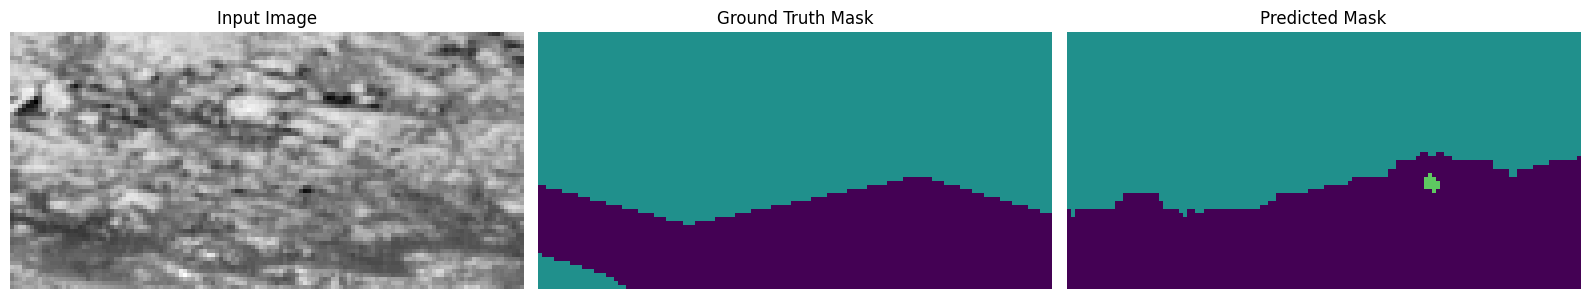

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 699ms/step - accuracy: 0.9381 - loss: 0.1647 - mean_iou: 0.5958 - val_accuracy: 0.7297 - val_loss: 0.8761 - val_mean_iou: 0.4130 - learning_rate: 0.0100
Epoch 102/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 685ms/step - accuracy: 0.9357 - loss: 0.1721 - mean_iou: 0.6229 - val_accuracy: 0.7807 - val_loss: 0.7315 - val_mean_iou: 0.4632 - learning_rate: 0.0100
Epoch 103/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 710ms/step - accuracy: 0.9447 - loss: 0.1472 - mean_iou: 0.6303 - val_accuracy: 0.6808 - val_loss: 1.0740 - val_mean_iou: 0.3496 - learning_rate: 0.0100
Epoch 104/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 700ms/step - accuracy: 0.9412 - loss: 0.1554 - mean_iou: 0.6223 - val_accuracy: 0.7606 - val_loss: 0.7712 - val_mean_iou: 0.4457 - learning_rate: 0.0100
Epoch 105/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 684ms/step - accuracy: 0.9453 - loss: 0.1460 - mean_iou: 0.6169 - val_accuracy: 0.7802 - val_loss: 0.6900 - val_mean_iou: 0.4694 - learning_rate: 0.0100
Epoch 106/500
30/30 ━━━━

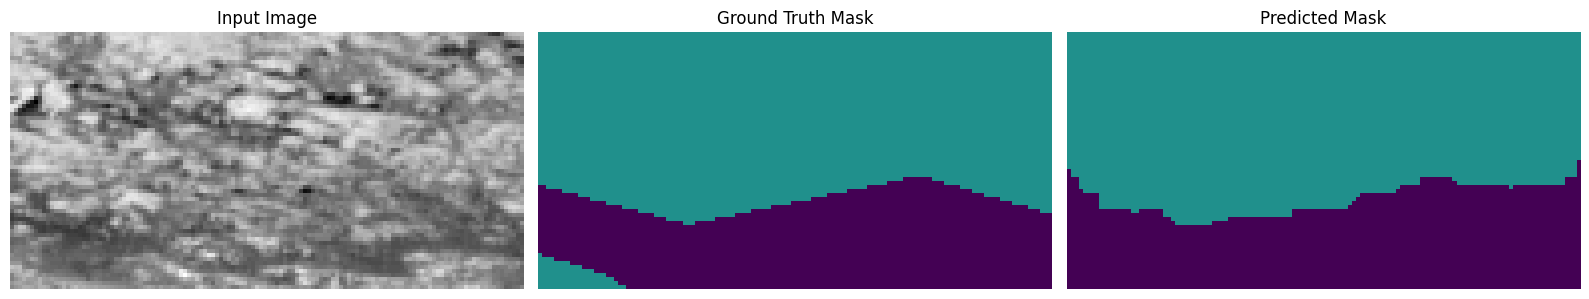

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 690ms/step - accuracy: 0.9486 - loss: 0.1352 - mean_iou: 0.6533 - val_accuracy: 0.7712 - val_loss: 0.6919 - val_mean_iou: 0.4652 - learning_rate: 0.0100
Epoch 107/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 697ms/step - accuracy: 0.9489 - loss: 0.1359 - mean_iou: 0.6521 - val_accuracy: 0.7480 - val_loss: 0.7982 - val_mean_iou: 0.4457 - learning_rate: 0.0100
Epoch 108/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 696ms/step - accuracy: 0.9478 - loss: 0.1395 - mean_iou: 0.6413 - val_accuracy: 0.7530 - val_loss: 0.8032 - val_mean_iou: 0.4325 - learning_rate: 0.0100
Epoch 109/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 692ms/step - accuracy: 0.9457 - loss: 0.1431 - mean_iou: 0.6663 - val_accuracy: 0.7118 - val_loss: 1.0265 - val_mean_iou: 0.3892 - learning_rate: 0.0100
Epoch 110/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 684ms/step - accuracy: 0.9399 - loss: 0.1593 - mean_iou: 0.6737 - val_accuracy: 0.6888 - val_loss: 1.0224 - val_mean_iou: 0.3964 - learning_rate: 0.0100
Epoch 111/500
30/30 ━━━━

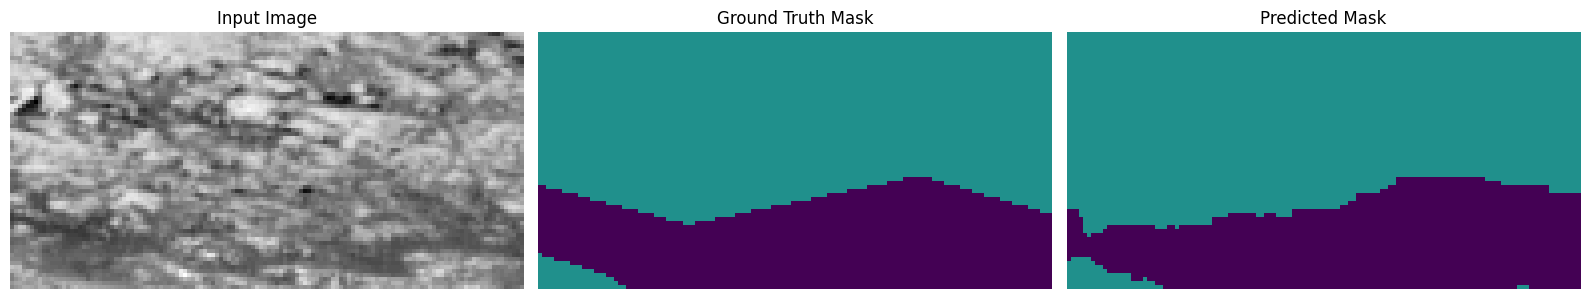

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 702ms/step - accuracy: 0.9502 - loss: 0.1329 - mean_iou: 0.6842 - val_accuracy: 0.7755 - val_loss: 0.7552 - val_mean_iou: 0.4606 - learning_rate: 0.0100
Epoch 112/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 695ms/step - accuracy: 0.9512 - loss: 0.1278 - mean_iou: 0.6490 - val_accuracy: 0.7566 - val_loss: 0.7795 - val_mean_iou: 0.4397 - learning_rate: 0.0100
Epoch 113/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 693ms/step - accuracy: 0.9542 - loss: 0.1185 - mean_iou: 0.6840 - val_accuracy: 0.7790 - val_loss: 0.7144 - val_mean_iou: 0.4848 - learning_rate: 0.0100
Epoch 114/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 689ms/step - accuracy: 0.9558 - loss: 0.1157 - mean_iou: 0.6931 - val_accuracy: 0.7700 - val_loss: 0.7385 - val_mean_iou: 0.4609 - learning_rate: 0.0100
Epoch 115/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 690ms/step - accuracy: 0.9514 - loss: 0.1337 - mean_iou: 0.6845 - val_accuracy: 0.7183 - val_loss: 0.9948 - val_mean_iou: 0.3913 - learning_rate: 0.0100
Epoch 116/500
30/30 ━━━━

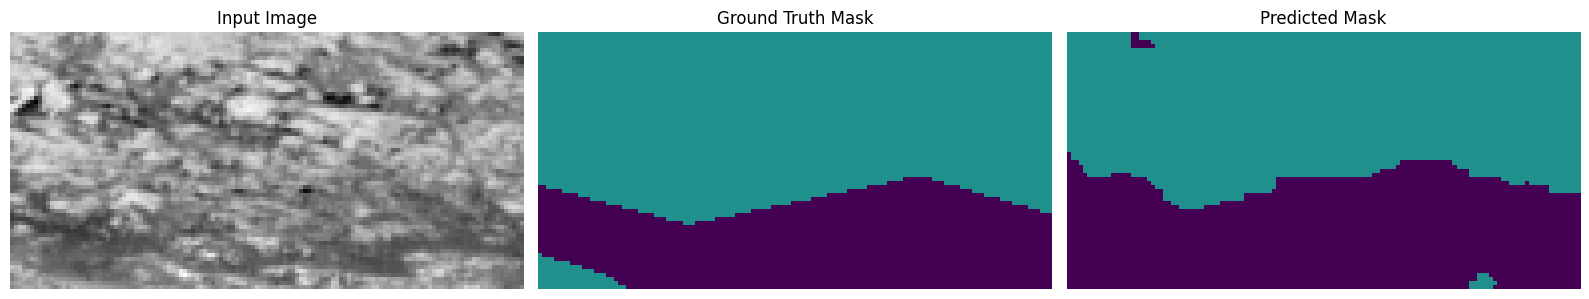

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 698ms/step - accuracy: 0.9543 - loss: 0.1195 - mean_iou: 0.7171 - val_accuracy: 0.7635 - val_loss: 0.7758 - val_mean_iou: 0.4451 - learning_rate: 0.0100
Epoch 117/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 692ms/step - accuracy: 0.9580 - loss: 0.1091 - mean_iou: 0.7013 - val_accuracy: 0.7731 - val_loss: 0.7597 - val_mean_iou: 0.4623 - learning_rate: 0.0100
Epoch 118/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 689ms/step - accuracy: 0.9573 - loss: 0.1110 - mean_iou: 0.7148 - val_accuracy: 0.7739 - val_loss: 0.7963 - val_mean_iou: 0.4539 - learning_rate: 0.0100
Epoch 119/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 688ms/step - accuracy: 0.9579 - loss: 0.1085 - mean_iou: 0.7118 - val_accuracy: 0.7798 - val_loss: 0.7364 - val_mean_iou: 0.4592 - learning_rate: 0.0100
Epoch 120/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 686ms/step - accuracy: 0.9605 - loss: 0.1028 - mean_iou: 0.7147 - val_accuracy: 0.7632 - val_loss: 0.7907 - val_mean_iou: 0.4400 - learning_rate: 0.0100
Epoch 121/500
30/30 ━━━━

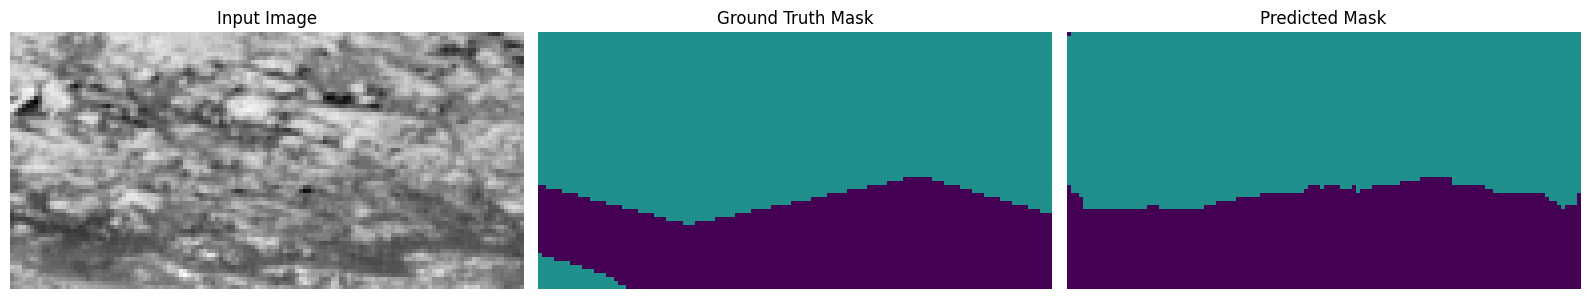

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 700ms/step - accuracy: 0.9622 - loss: 0.0961 - mean_iou: 0.7213 - val_accuracy: 0.7808 - val_loss: 0.7187 - val_mean_iou: 0.4630 - learning_rate: 0.0100
Epoch 122/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 687ms/step - accuracy: 0.9639 - loss: 0.0918 - mean_iou: 0.7189 - val_accuracy: 0.7671 - val_loss: 0.8046 - val_mean_iou: 0.4537 - learning_rate: 0.0100
Epoch 123/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 697ms/step - accuracy: 0.9665 - loss: 0.0854 - mean_iou: 0.7346 - val_accuracy: 0.7933 - val_loss: 0.7305 - val_mean_iou: 0.4839 - learning_rate: 0.0100
Epoch 124/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 693ms/step - accuracy: 0.9664 - loss: 0.0860 - mean_iou: 0.7163 - val_accuracy: 0.7800 - val_loss: 0.7710 - val_mean_iou: 0.4721 - learning_rate: 0.0100
Epoch 125/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 691ms/step - accuracy: 0.9629 - loss: 0.0978 - mean_iou: 0.7213 - val_accuracy: 0.7182 - val_loss: 1.0809 - val_mean_iou: 0.3903 - learning_rate: 0.0100
Epoch 126/500
30/30 ━━━━

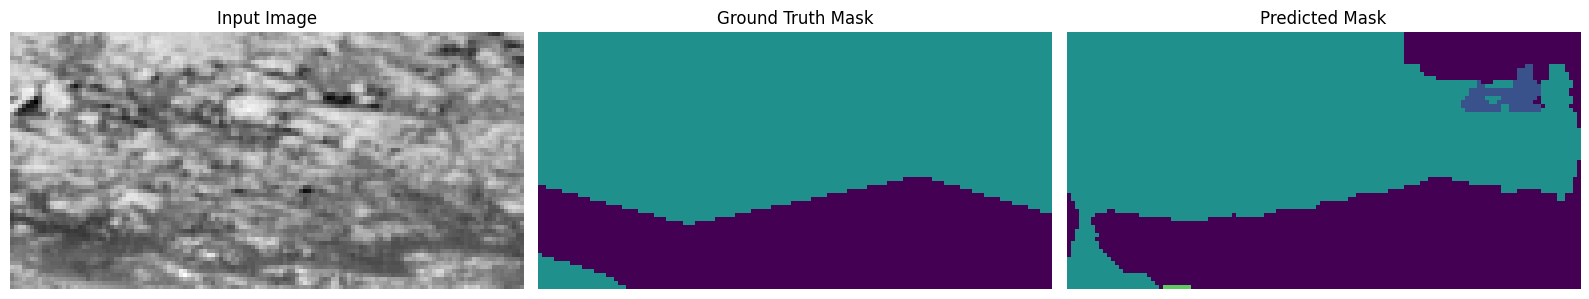

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 699ms/step - accuracy: 0.9560 - loss: 0.1195 - mean_iou: 0.6903 - val_accuracy: 0.7687 - val_loss: 0.8338 - val_mean_iou: 0.4616 - learning_rate: 0.0100
Epoch 127/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 689ms/step - accuracy: 0.9576 - loss: 0.1103 - mean_iou: 0.7063 - val_accuracy: 0.6716 - val_loss: 1.5226 - val_mean_iou: 0.3455 - learning_rate: 0.0100
Epoch 128/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 687ms/step - accuracy: 0.9609 - loss: 0.1015 - mean_iou: 0.7144 - val_accuracy: 0.7202 - val_loss: 0.9552 - val_mean_iou: 0.4041 - learning_rate: 0.0100
Epoch 129/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 686ms/step - accuracy: 0.9602 - loss: 0.1035 - mean_iou: 0.7228 - val_accuracy: 0.7758 - val_loss: 0.7817 - val_mean_iou: 0.4619 - learning_rate: 0.0100
Epoch 130/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 696ms/step - accuracy: 0.9631 - loss: 0.0957 - mean_iou: 0.7191 - val_accuracy: 0.7946 - val_loss: 0.7405 - val_mean_iou: 0.4883 - learning_rate: 0.0100
Epoch 131/500
30/30 ━━━━

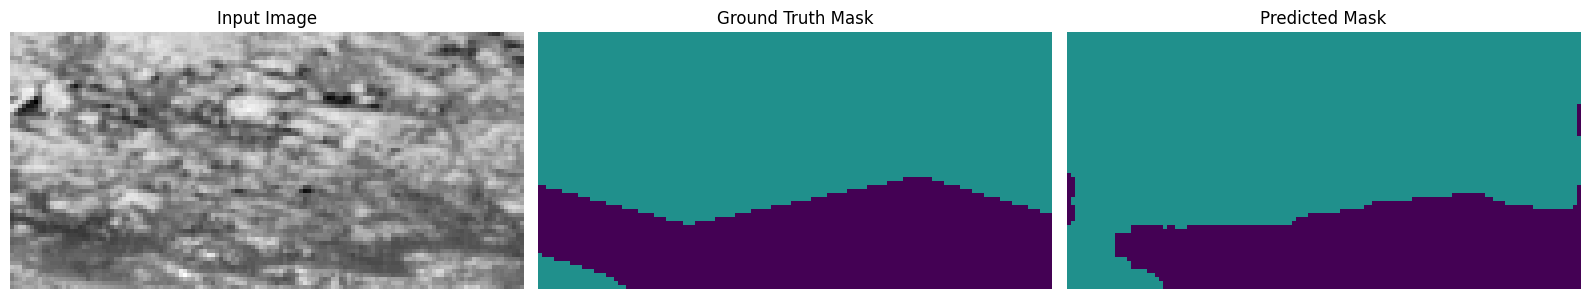

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 703ms/step - accuracy: 0.9647 - loss: 0.0895 - mean_iou: 0.7192 - val_accuracy: 0.7839 - val_loss: 0.7478 - val_mean_iou: 0.4814 - learning_rate: 0.0100
Epoch 132/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 693ms/step - accuracy: 0.9653 - loss: 0.0904 - mean_iou: 0.6864 - val_accuracy: 0.7673 - val_loss: 0.8124 - val_mean_iou: 0.4501 - learning_rate: 0.0100
Epoch 133/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 690ms/step - accuracy: 0.9664 - loss: 0.0849 - mean_iou: 0.7175 - val_accuracy: 0.7414 - val_loss: 0.9610 - val_mean_iou: 0.4191 - learning_rate: 0.0100
Epoch 134/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 690ms/step - accuracy: 0.9656 - loss: 0.0881 - mean_iou: 0.7302 - val_accuracy: 0.7719 - val_loss: 0.8809 - val_mean_iou: 0.4528 - learning_rate: 0.0100
Epoch 135/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 692ms/step - accuracy: 0.9673 - loss: 0.0828 - mean_iou: 0.7132 - val_accuracy: 0.7651 - val_loss: 0.9294 - val_mean_iou: 0.4437 - learning_rate: 0.0100
Epoch 136/500
30/30 ━━━━

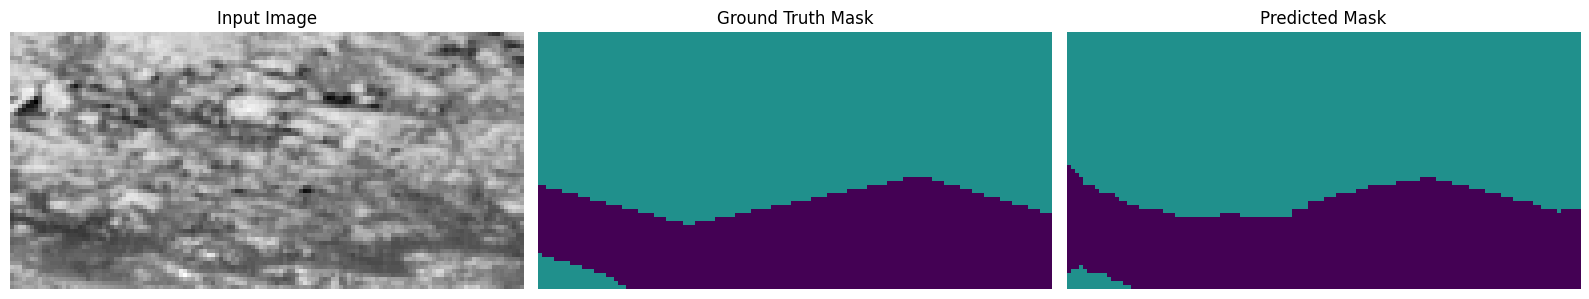

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 705ms/step - accuracy: 0.9678 - loss: 0.0816 - mean_iou: 0.7277 - val_accuracy: 0.7760 - val_loss: 0.8121 - val_mean_iou: 0.4694 - learning_rate: 0.0100
Epoch 137/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 40s 685ms/step - accuracy: 0.9667 - loss: 0.0850 - mean_iou: 0.7410 - val_accuracy: 0.7682 - val_loss: 0.7991 - val_mean_iou: 0.4584 - learning_rate: 0.0100
Epoch 138/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 715ms/step - accuracy: 0.9687 - loss: 0.0789 - mean_iou: 0.7186 - val_accuracy: 0.7847 - val_loss: 0.8070 - val_mean_iou: 0.4891 - learning_rate: 0.0100
Epoch 139/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 699ms/step - accuracy: 0.9666 - loss: 0.0843 - mean_iou: 0.7226 - val_accuracy: 0.7529 - val_loss: 0.8645 - val_mean_iou: 0.4444 - learning_rate: 0.0100
Epoch 140/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 682ms/step - accuracy: 0.9692 - loss: 0.0779 - mean_iou: 0.7333 - val_accuracy: 0.6738 - val_loss: 1.4692 - val_mean_iou: 0.3462 - learning_rate: 0.0100
Epoch 141/500
30/30 ━━━━

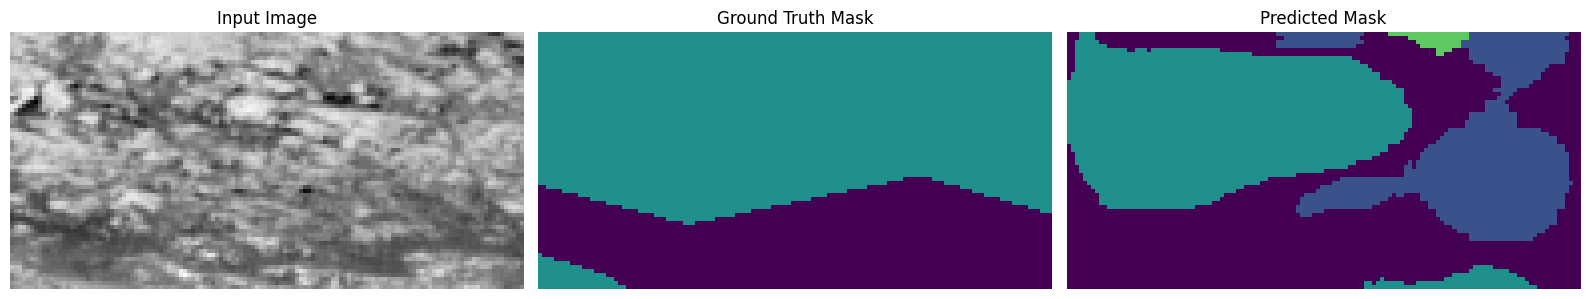

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 693ms/step - accuracy: 0.9644 - loss: 0.0918 - mean_iou: 0.7117 - val_accuracy: 0.6835 - val_loss: 1.3357 - val_mean_iou: 0.3513 - learning_rate: 0.0100
Epoch 142/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 696ms/step - accuracy: 0.9640 - loss: 0.0932 - mean_iou: 0.7299 - val_accuracy: 0.6686 - val_loss: 1.4665 - val_mean_iou: 0.3448 - learning_rate: 0.0100
Epoch 143/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 695ms/step - accuracy: 0.9590 - loss: 0.1159 - mean_iou: 0.7294 - val_accuracy: 0.5712 - val_loss: 3.2702 - val_mean_iou: 0.2682 - learning_rate: 0.0100
Epoch 144/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 688ms/step - accuracy: 0.9124 - loss: 0.2370 - mean_iou: 0.6623 - val_accuracy: 0.6578 - val_loss: 2.6802 - val_mean_iou: 0.3262 - learning_rate: 0.0100
Epoch 145/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 687ms/step - accuracy: 0.9116 - loss: 0.2432 - mean_iou: 0.6178 - val_accuracy: 0.6033 - val_loss: 2.0424 - val_mean_iou: 0.3090 - learning_rate: 0.0100
Epoch 146/500
30/30 ━━━━

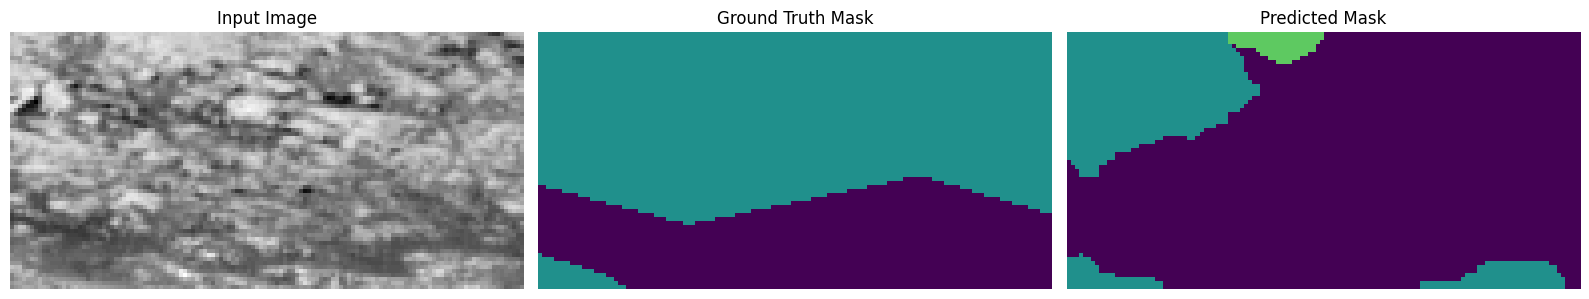

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 701ms/step - accuracy: 0.9237 - loss: 0.2093 - mean_iou: 0.6460 - val_accuracy: 0.5028 - val_loss: 2.5983 - val_mean_iou: 0.2360 - learning_rate: 0.0100
Epoch 147/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 691ms/step - accuracy: 0.9447 - loss: 0.1458 - mean_iou: 0.7168 - val_accuracy: 0.7113 - val_loss: 1.2553 - val_mean_iou: 0.4196 - learning_rate: 0.0100
Epoch 148/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 687ms/step - accuracy: 0.9600 - loss: 0.1048 - mean_iou: 0.7267 - val_accuracy: 0.7142 - val_loss: 1.1624 - val_mean_iou: 0.4371 - learning_rate: 0.0100
Epoch 149/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 691ms/step - accuracy: 0.9634 - loss: 0.0946 - mean_iou: 0.6897 - val_accuracy: 0.7576 - val_loss: 0.9263 - val_mean_iou: 0.4672 - learning_rate: 0.0100
Epoch 150/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 692ms/step - accuracy: 0.9650 - loss: 0.0903 - mean_iou: 0.7354 - val_accuracy: 0.7605 - val_loss: 0.8627 - val_mean_iou: 0.4681 - learning_rate: 0.0100
Epoch 151/500
30/30 ━━━━

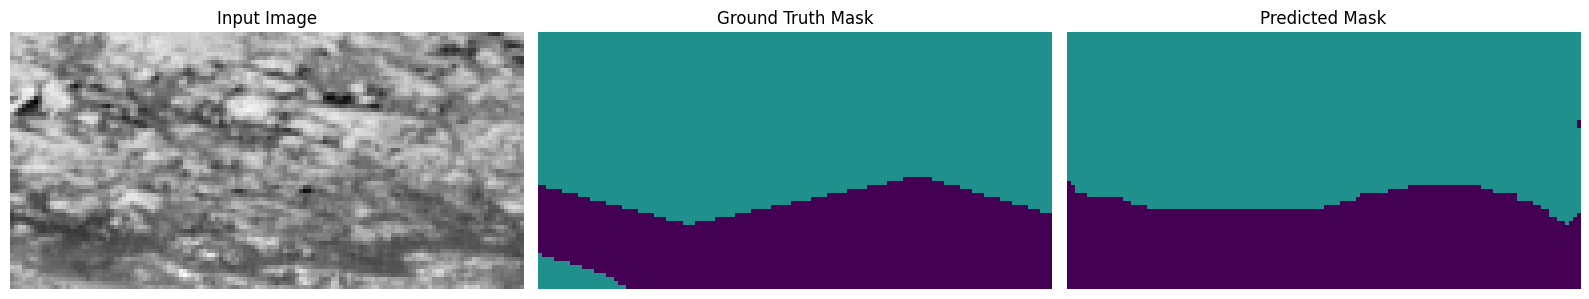

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 701ms/step - accuracy: 0.9697 - loss: 0.0766 - mean_iou: 0.7399 - val_accuracy: 0.7808 - val_loss: 0.8005 - val_mean_iou: 0.4742 - learning_rate: 0.0100
Epoch 152/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 692ms/step - accuracy: 0.9706 - loss: 0.0742 - mean_iou: 0.7481 - val_accuracy: 0.7856 - val_loss: 0.7431 - val_mean_iou: 0.4837 - learning_rate: 0.0100
Epoch 153/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 693ms/step - accuracy: 0.9713 - loss: 0.0727 - mean_iou: 0.7464 - val_accuracy: 0.7706 - val_loss: 0.8593 - val_mean_iou: 0.4603 - learning_rate: 0.0100
Epoch 154/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 692ms/step - accuracy: 0.9688 - loss: 0.0783 - mean_iou: 0.7370 - val_accuracy: 0.7772 - val_loss: 0.8359 - val_mean_iou: 0.4604 - learning_rate: 0.0100
Epoch 155/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 689ms/step - accuracy: 0.9734 - loss: 0.0667 - mean_iou: 0.7420 - val_accuracy: 0.7794 - val_loss: 0.8360 - val_mean_iou: 0.4736 - learning_rate: 0.0100
Epoch 156/500
30/30 ━━━━

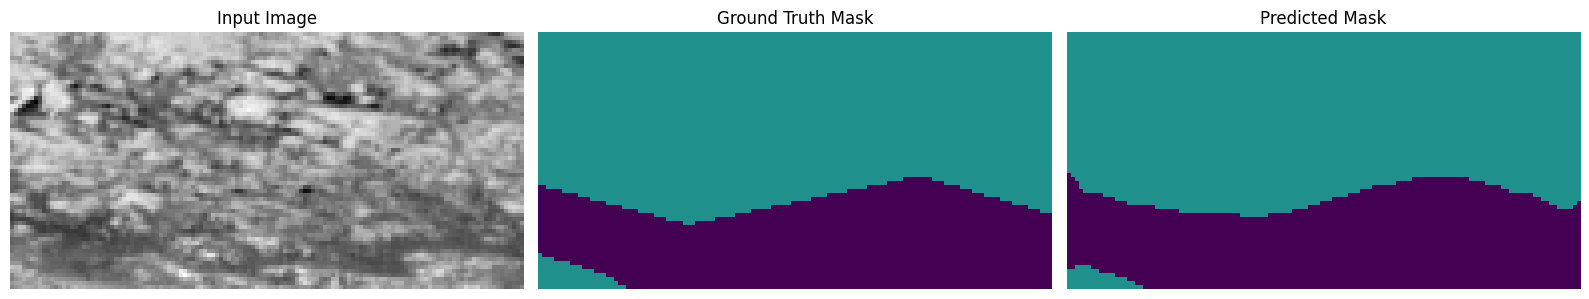

30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 697ms/step - accuracy: 0.9750 - loss: 0.0627 - mean_iou: 0.7454 - val_accuracy: 0.7821 - val_loss: 0.8402 - val_mean_iou: 0.4740 - learning_rate: 0.0100
Epoch 157/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 689ms/step - accuracy: 0.9740 - loss: 0.0653 - mean_iou: 0.7227 - val_accuracy: 0.7774 - val_loss: 0.8203 - val_mean_iou: 0.4801 - learning_rate: 0.0100
Epoch 158/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 691ms/step - accuracy: 0.9738 - loss: 0.0653 - mean_iou: 0.7392 - val_accuracy: 0.7793 - val_loss: 0.8621 - val_mean_iou: 0.4719 - learning_rate: 0.0100
Epoch 159/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 691ms/step - accuracy: 0.9745 - loss: 0.0637 - mean_iou: 0.7426 - val_accuracy: 0.7833 - val_loss: 0.8558 - val_mean_iou: 0.4744 - learning_rate: 0.0100
Epoch 160/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 692ms/step - accuracy: 0.9746 - loss: 0.0628 - mean_iou: 0.7420 - val_accuracy: 0.7739 - val_loss: 0.8904 - val_mean_iou: 0.4628 - learning_rate: 0.0100
Final validation Mean In

In [21]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback, reduceOnPlateau],
    batch_size=BATCH_SIZE,
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'model_UNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
#del model

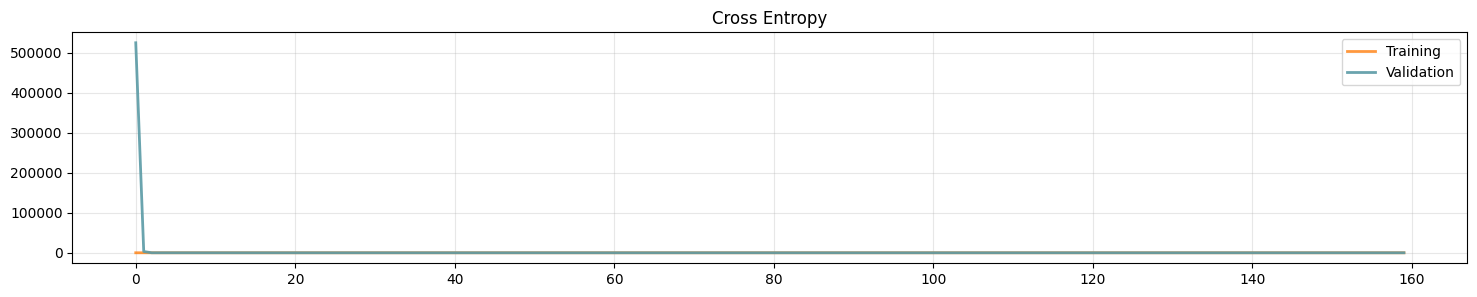

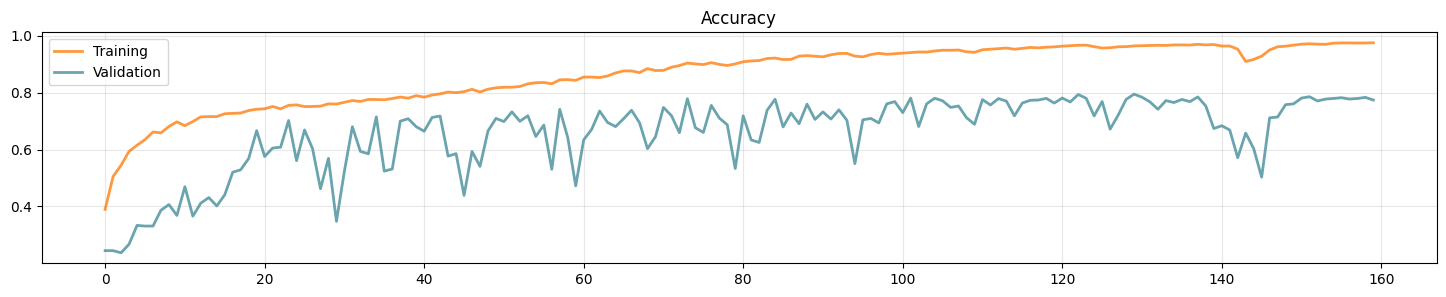

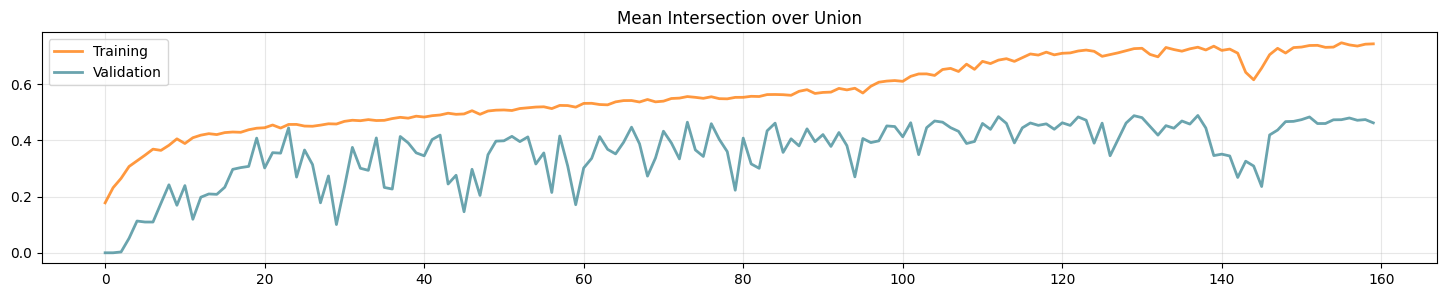

In [22]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [23]:
## If model_filename is not defined, load the most recent model from Google Drive
#if "model_filename" not in globals() or model_filename is None:
#    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
#    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
#    if files:
#        model_filename = files[0]
#    else:
#        raise FileNotFoundError("No model files found in the current directory.")

In [24]:


#start_key = 586
#end_key = 10500  # Adjust this based on the expected range
#increment = 128
#
## Function to dynamically create custom_objects
#custom_objects = {
#    f'keras_tensor_{key}': repeat_elem
#    for key in range(start_key, end_key, increment)
#}
#
#
#model = tfk.models.load_model(model_filename, compile=False, safe_mode=False, custom_objects=custom_objects)
print(f"Model loaded from {model_filename}")

Model loaded from model_UNet_48.91.keras


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 855ms/step
Predictions shape: (300, 64, 128)


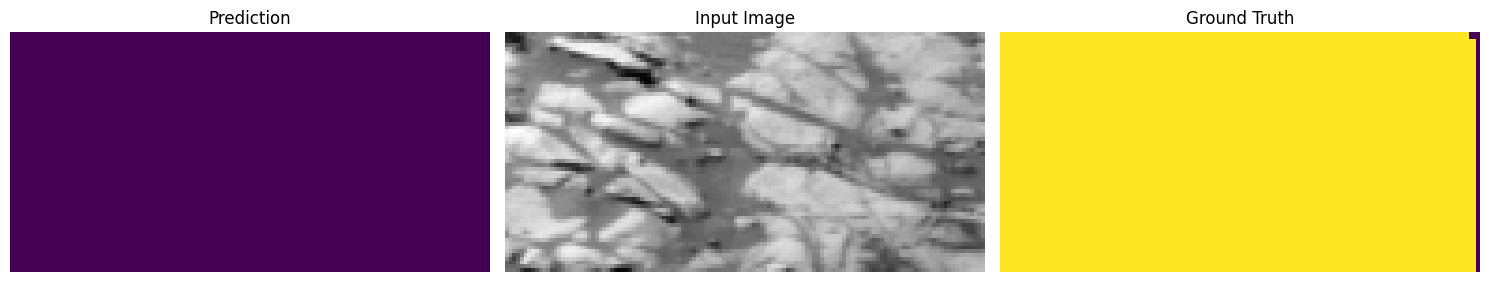

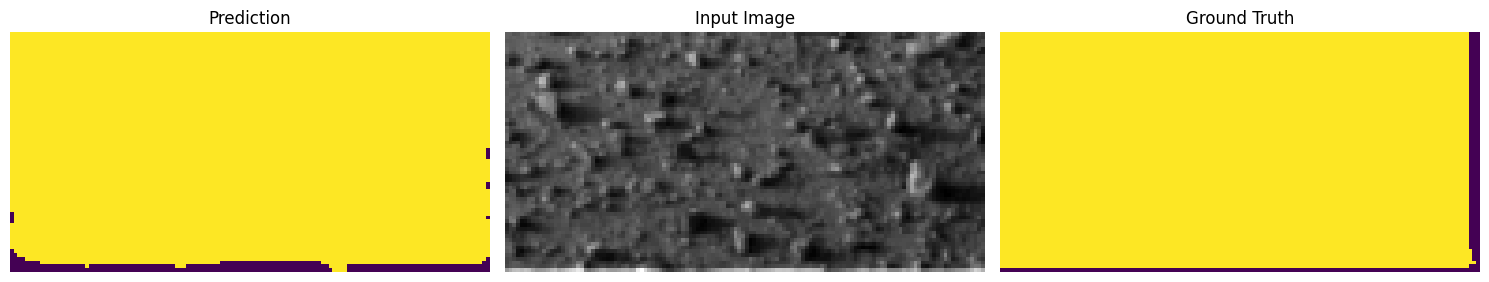

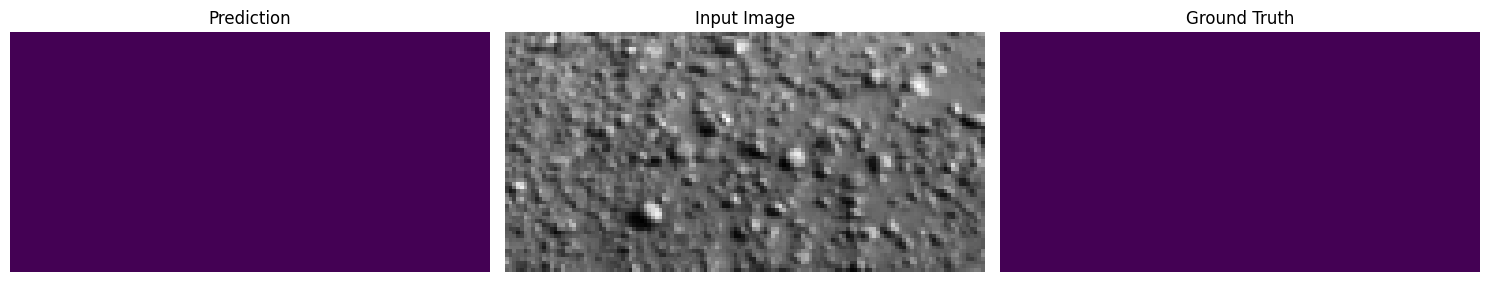

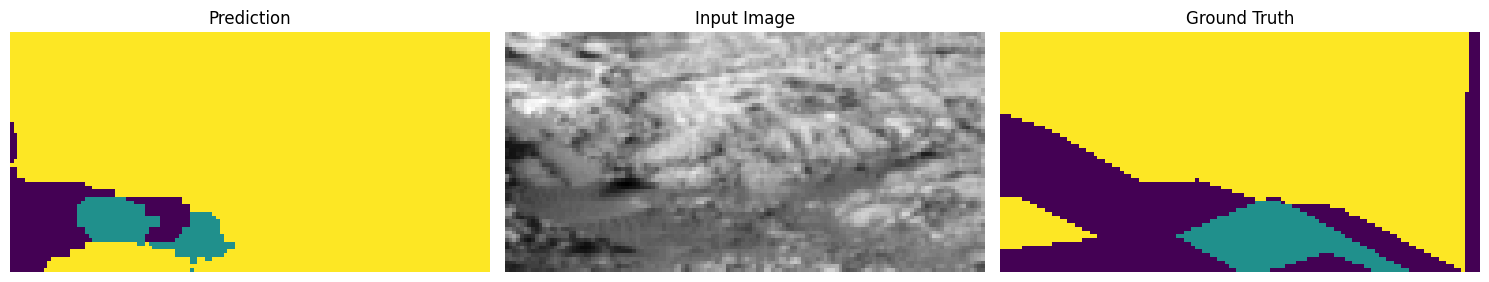

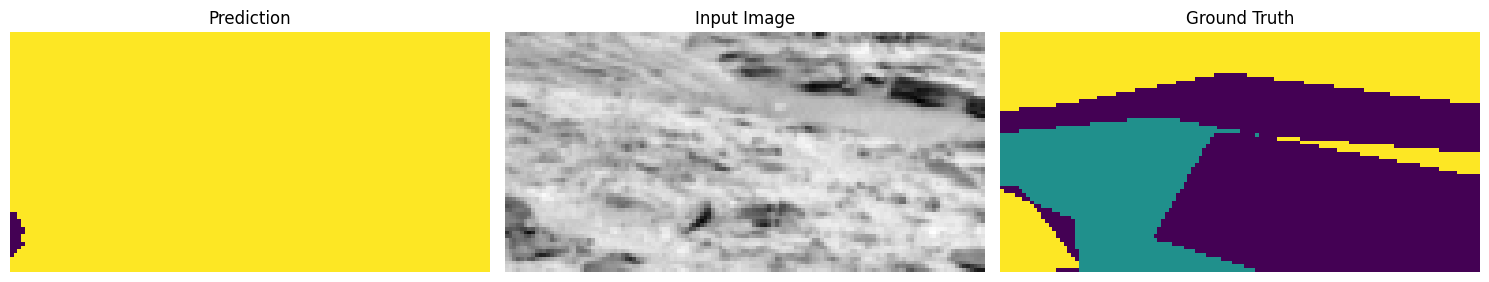

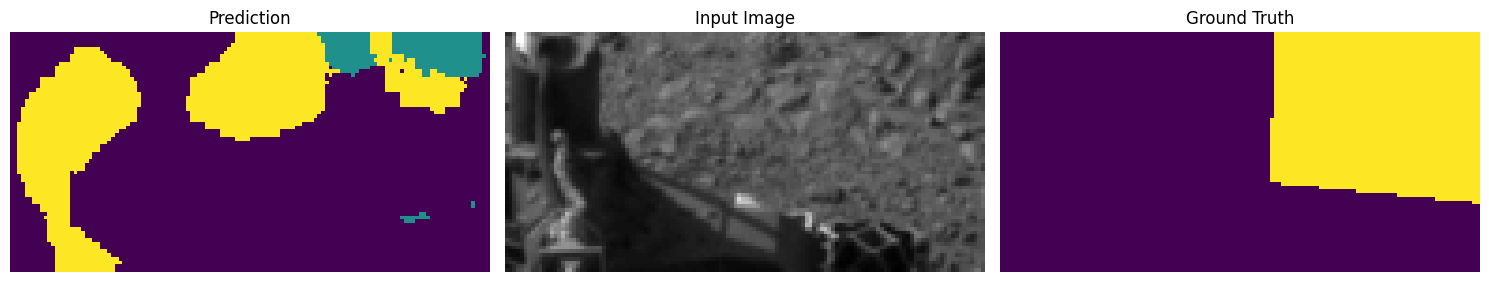

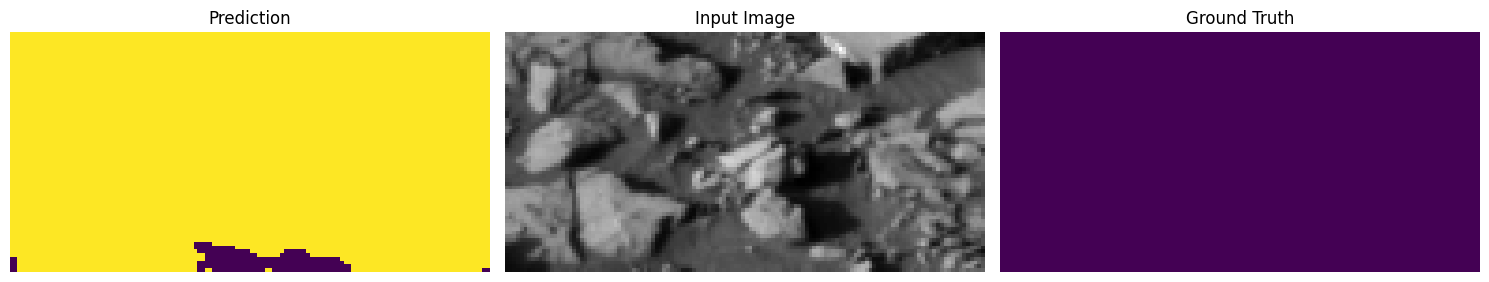

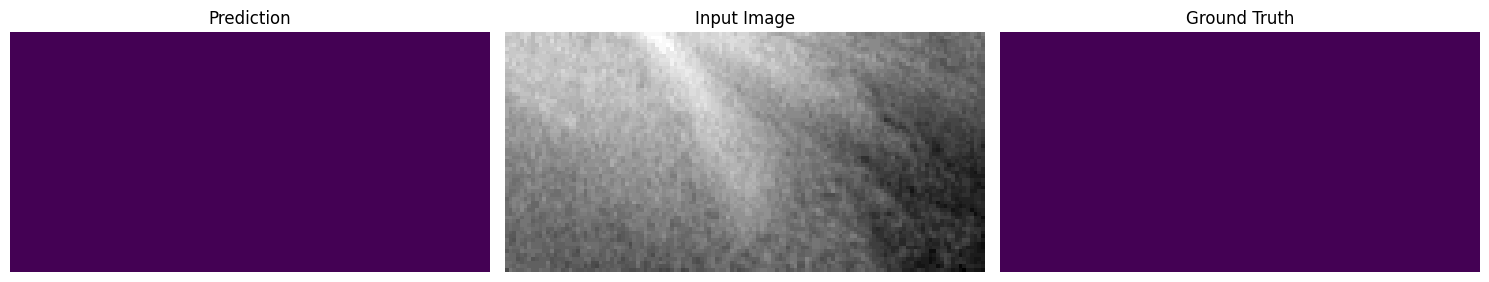

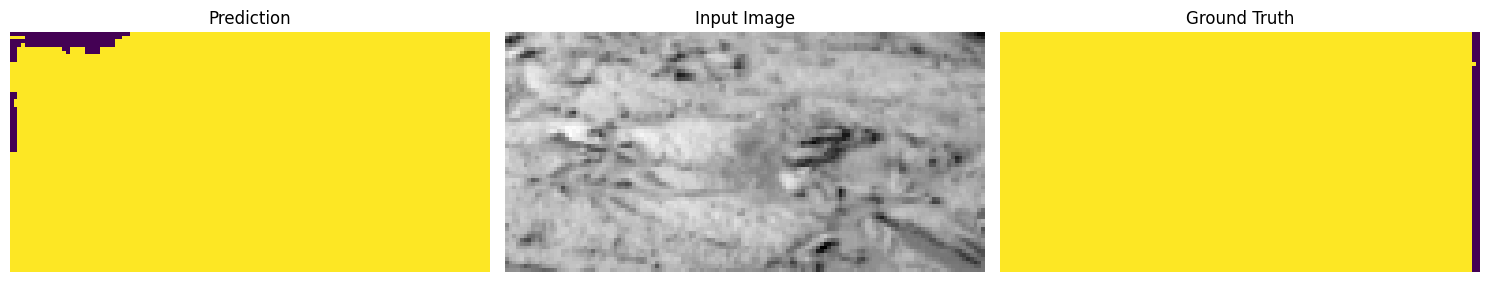

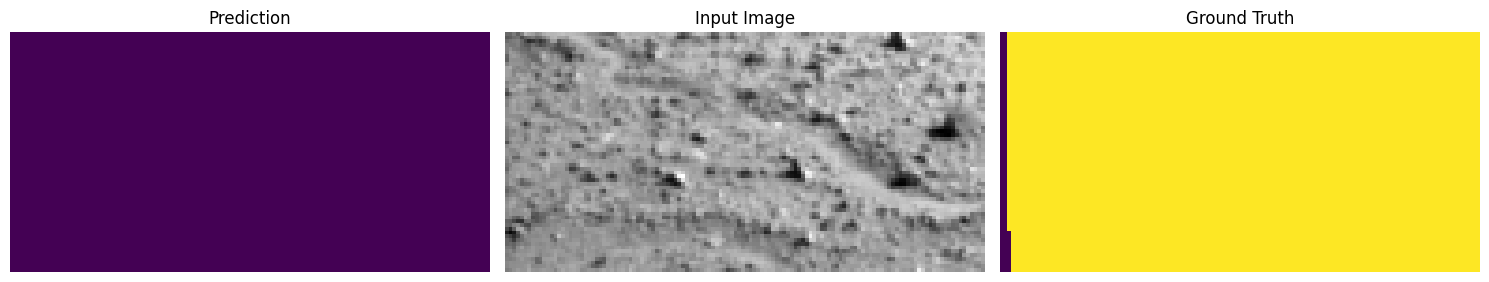

In [25]:
preds = model.predict(test_dataset)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")
#accuracy
#show predictions ....
for i in range(10):
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure with 3 subplots

  # Prediction
  axes[0].imshow(preds[i])
  axes[0].set_title("Prediction")
  axes[0].axis('off')  # Turn off axis labels

  # Input image
  axes[1].imshow(test_img[i], cmap='gray')
  axes[1].set_title("Input Image")
  axes[1].axis('off')

  # Ground truth label
  axes[2].imshow(test_lbl[i])
  axes[2].set_title("Ground Truth")
  axes[2].axis('off')

  plt.tight_layout()  # Adjust subplot parameters for a tight layout
  plt.show()


314/314 ━━━━━━━━━━━━━━━━━━━━ 52s 123ms/step
(10022, 64, 128)


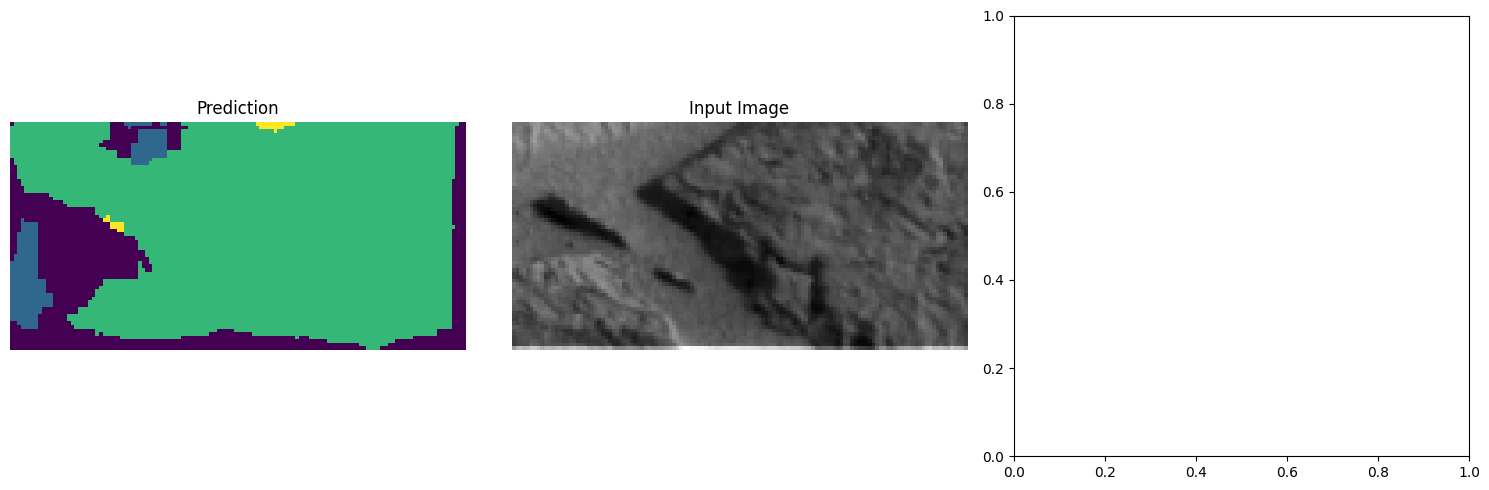

(10022, 64, 128)


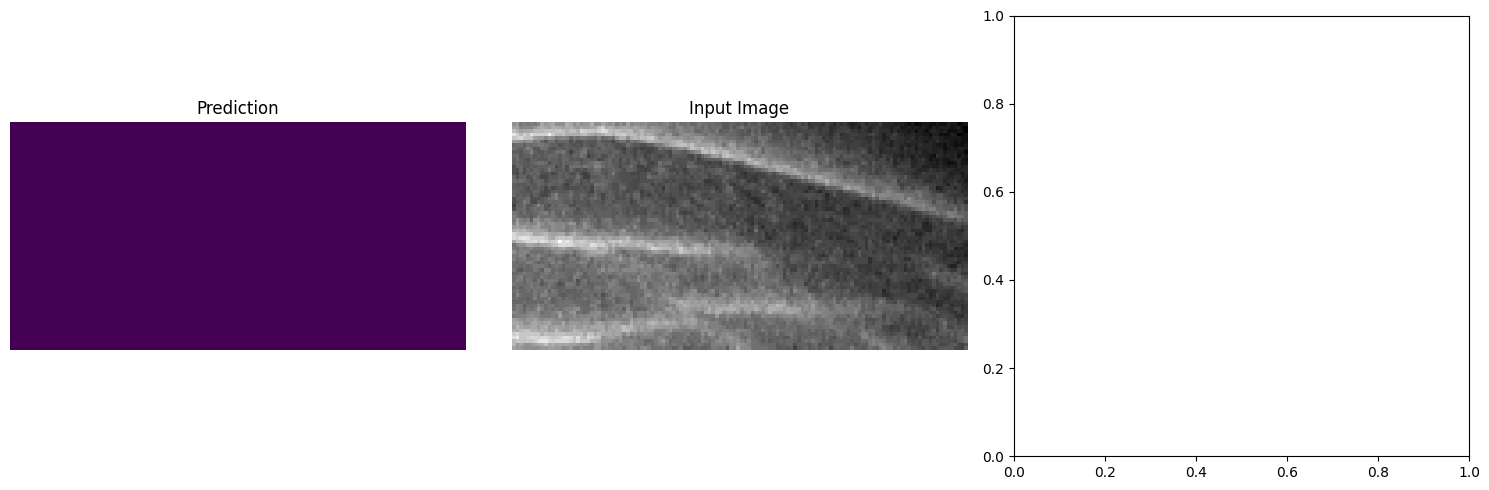

(10022, 64, 128)


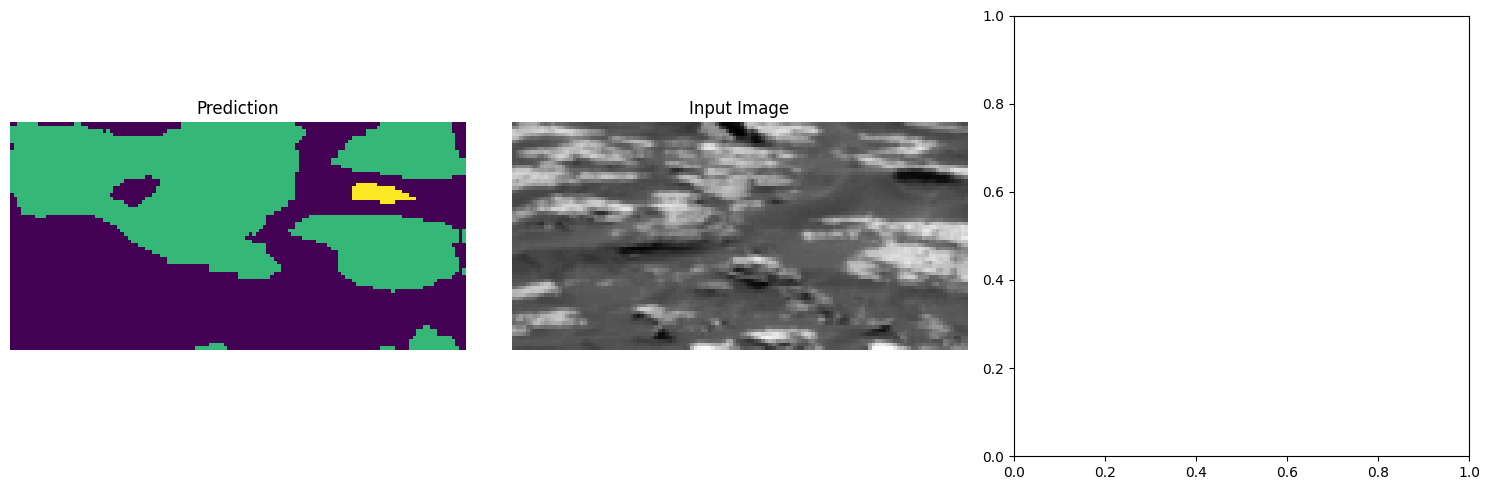

(10022, 64, 128)


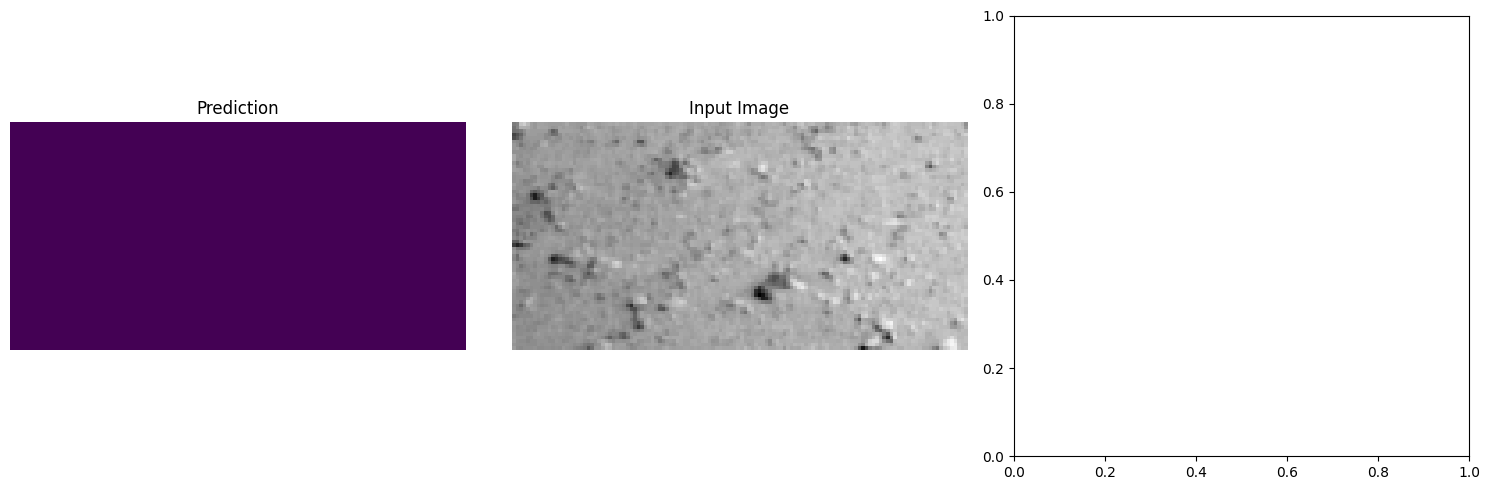

(10022, 64, 128)


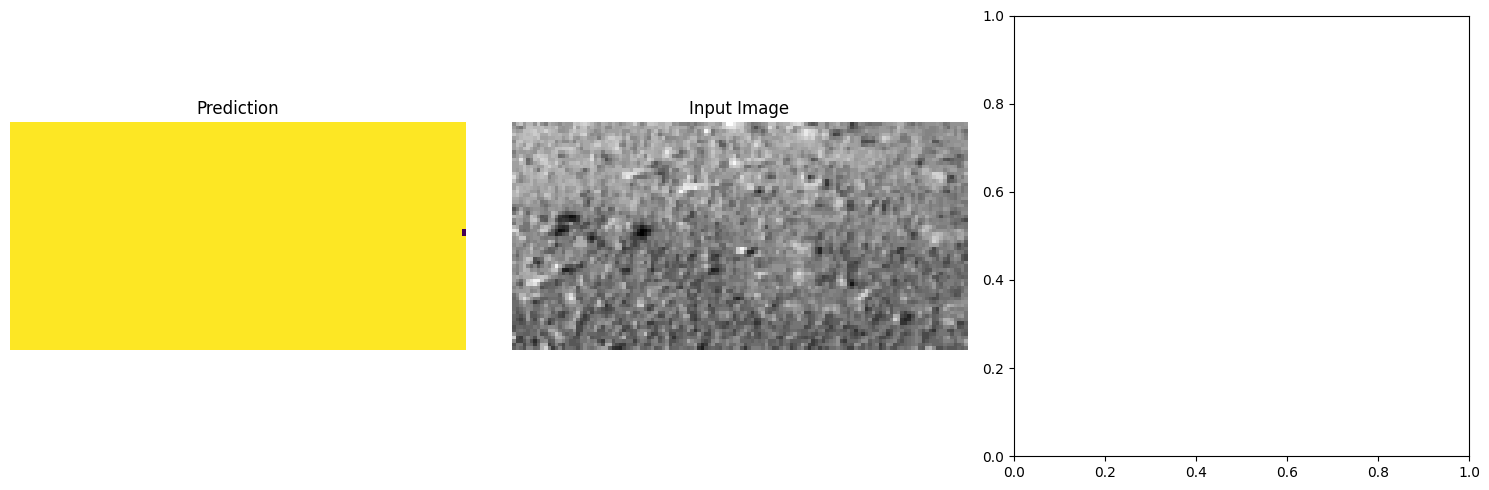

(10022, 64, 128)


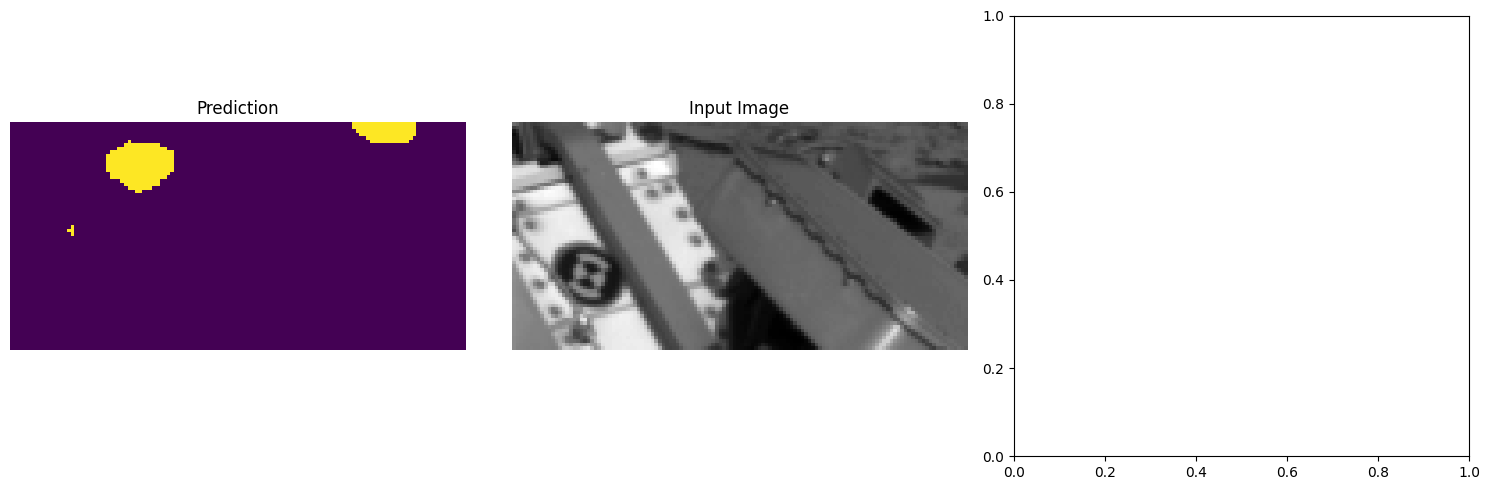

(10022, 64, 128)


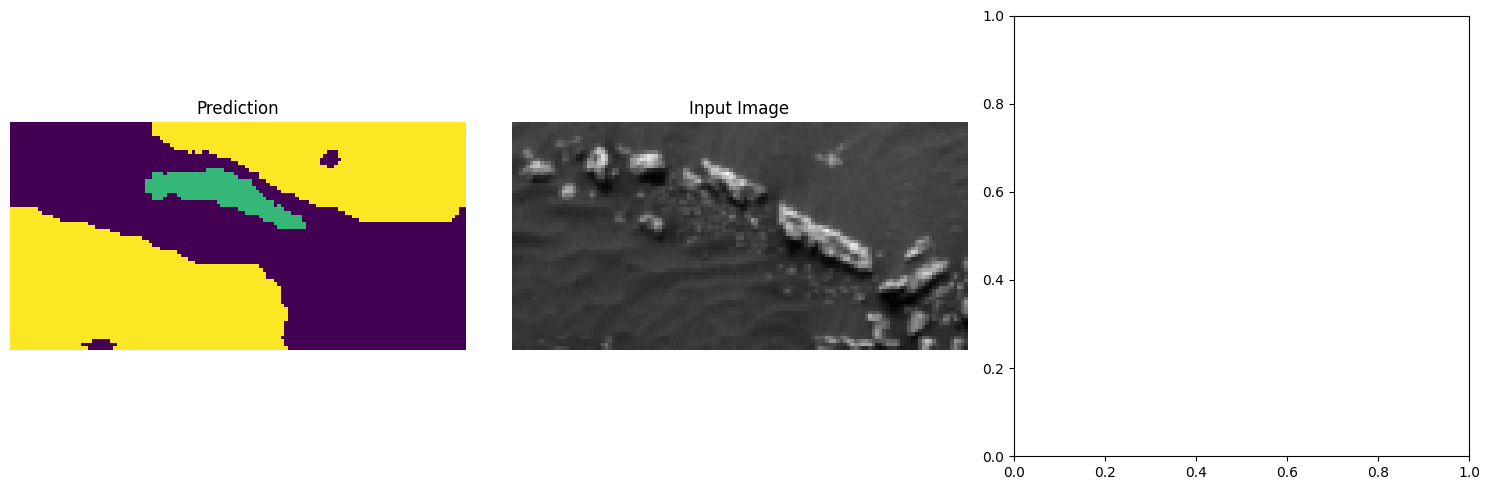

(10022, 64, 128)


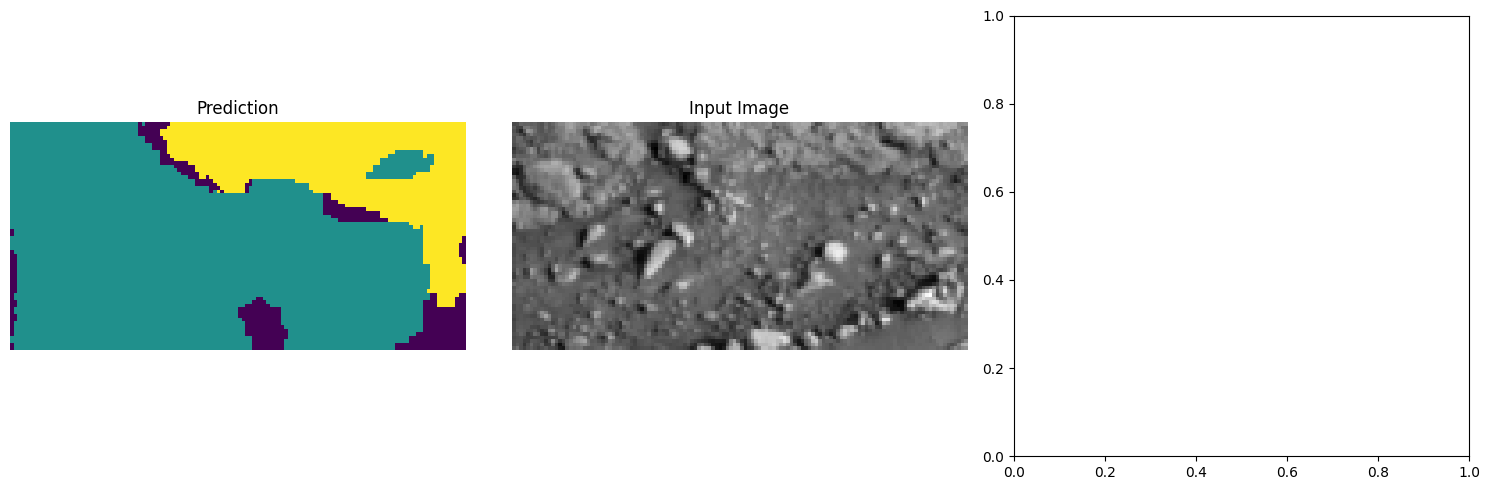

(10022, 64, 128)


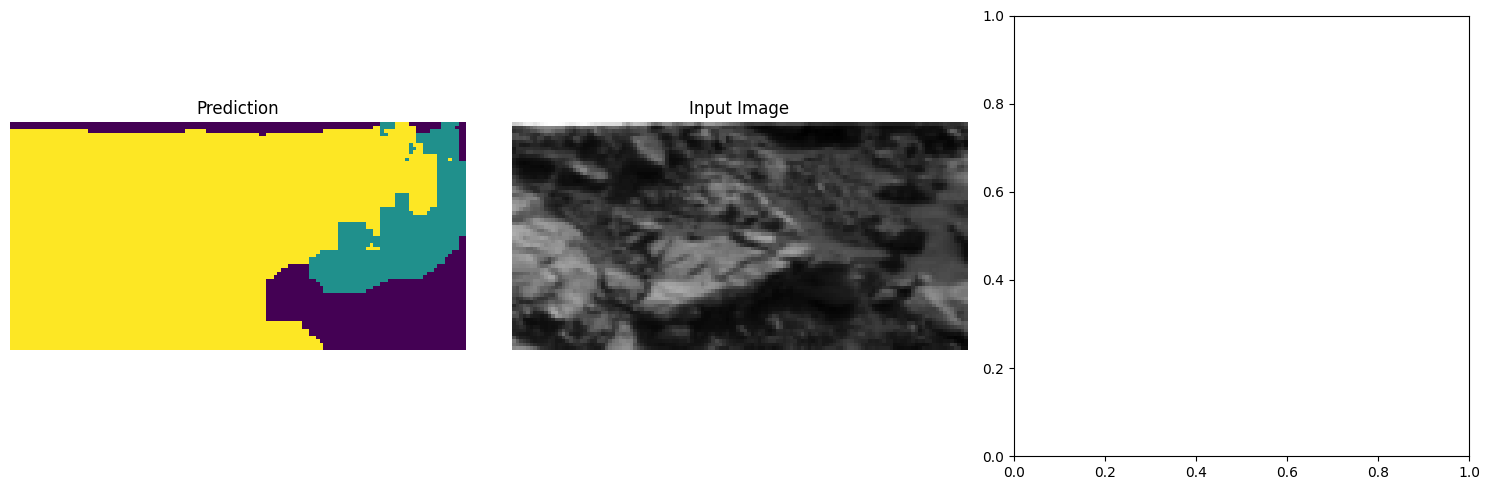

(10022, 64, 128)


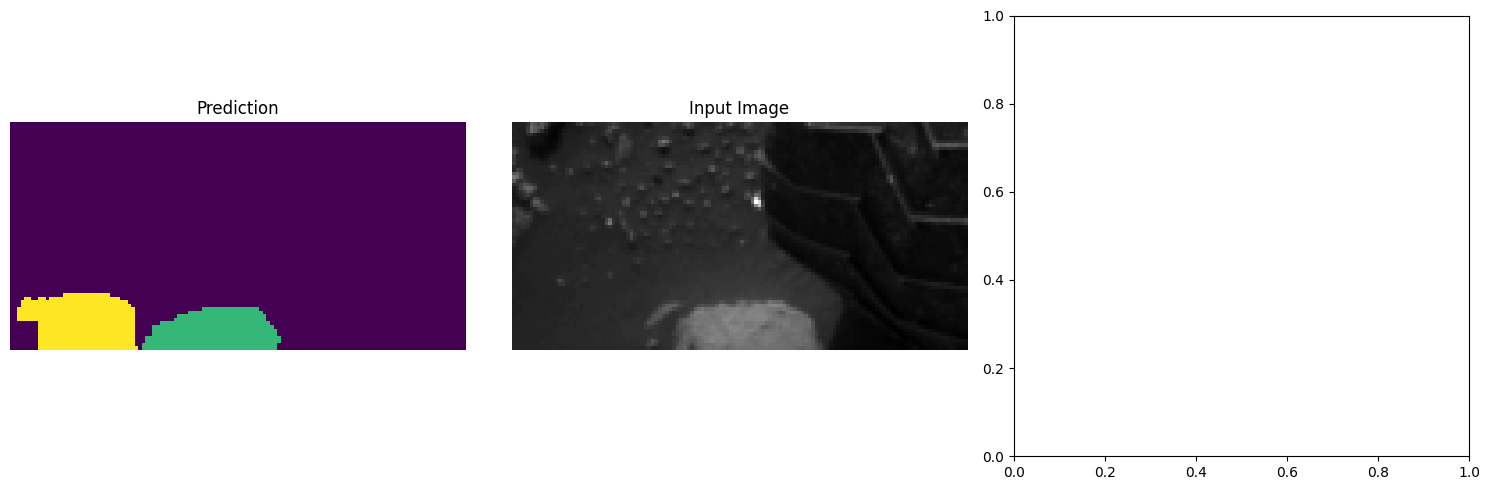

In [26]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)

for i in range(10):
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure with 3 subplots

  print(preds.shape)
  # Prediction
  axes[0].imshow(preds[i])
  axes[0].set_title("Prediction")
  axes[0].axis('off')  # Turn off axis labels

  # Input image
  axes[1].imshow(X_test[i], cmap='gray')
  axes[1].set_title("Input Image")
  axes[1].axis('off')

  plt.tight_layout()  # Adjust subplot parameters for a tight layout
  plt.show()


In [27]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [28]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```